In [141]:
import pandas as pd
import numpy as np
import missingno as msno

from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV, SelectFromModel
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, auc

# Analisis del dataset

El dataset que se estara estudiando sera para poder predecir si el cliente de un determinado banco abandonara el mismo o no.

Las columnas con las cuales cuenta el dataset son:
- 'CLIENTNUM': Numero de cliente. Identificador unico del cliente que tiene la cuenta.
- 'Attrition_Flag': Variable target, actividad del cliente si esta activo o inactivo.
- 'Customer_Age': Variable demografica. Edad del cliente.
- 'Gender': Variable demografica. Sexo del cliente.
- 'Dependent_Count': Variable demografica. Nuemero de dependientes o personas que dependen del cliente.
- 'Education_Level': Variable demografica. Nivel de educacion del cliente.
- 'Marital_Status': Variable demografica. Estado marital.
- 'Income_Category': Variable categorica, ingresos anuales en dolares expresado en intervalos.
- 'Card_Category': Tipo de tarjeta de credito (Blue, Silver, Gold, Platinum).
- 'Months_on_book': Tiempo de relacion con el banco (medido en meses).
- 'Total_Relationship_Count': Numero de productos retenidos por el cliente.
- 'Months_Inactive_12_mon': Numero de meses inactivos en los ultimos 12 meses.
- 'Contacts_Count_12_mon': Numero de contactos en los ultimos 12 meses.
- 'Credit_Limit': Limite de credito en la tarjeta de credito.
- 'Total_Revolving_Bal': saldo rotatorio total en la tarjeta de credito.
- 'Avg_Open_To_Buy': Abierto a comprar linea de credito (promedio de los ultimos 12 meses).
- 'Total_Amt_Chng_Q4_Q1': Cambio en las transacciones.
- 'Total_Trans_Amt': Monto total en las transacciones (ultimos 12 meses).
- 'Total_Trans_Ct': Conteo total de las transacciones realizadas (ultimos 12 meses).
- 'Total_Ct_Chng_Q4_Q1': Cambio en el conteo de transacciones.
- 'Avg_Utilization_Ratio': Ratio de uso medio de la tarjeta.

In [142]:
# Cargo DataSet.
data = pd.read_csv('BankChurners.csv')

# Elimino columnas innecesarias.
data.drop(columns=['CLIENTNUM', 'Unnamed: 0'], inplace=True)

# Imprimo cantidad de filas y columnas.
print('El dataset contiene', data.shape[0], 'filas')
print('El dataset contiene', data.shape[1], 'columnas')

El dataset contiene 10127 filas
El dataset contiene 20 columnas


In [143]:
print(data.shape)
data.head()

(10127, 20)


Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [144]:
# Obtengo los tipo de datos de las columnas.
data.dtypes

Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

Veremos que tan desbalanceada esta la variable target.

In [145]:
# Cambio de nombre los registros de mi variable target -- Existing Customer : 0 -- Attrited Customer : 1.
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

# Veo el balance de la clase target.
data['Attrition_Flag'].value_counts(normalize=True)

0    0.83934
1    0.16066
Name: Attrition_Flag, dtype: float64

In [146]:
# Veo cantidad de casos de la clase target.
data['Attrition_Flag'].value_counts(normalize=False)

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

Veremos si hay registros con valores faltantes.

In [147]:
# Sumo mis registros nulos.
null_count = data.isnull().sum()

# Creo mascara para mostrar mis registros nulos.
mask_null = null_count > 0

print('Cantidad de nulos')

# Aplico mascara al DataSet para mostrar los registros con nulos.
null_count[mask_null]

Cantidad de nulos


Series([], dtype: int64)

Veremos la correlacion de las distintas variables, y nos quedaremos unicamente con la variable target.

<AxesSubplot:>

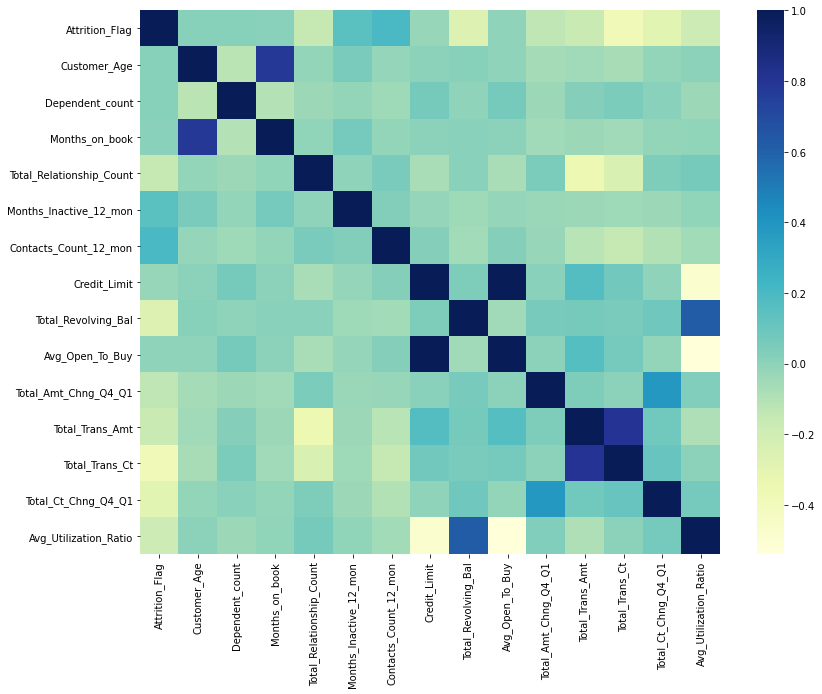

In [148]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), cmap="YlGnBu")

In [149]:
pd.DataFrame(data.corr()['Attrition_Flag'])

Attrition_Flag
Attrition_Flag                  1.000000
Customer_Age                    0.018203
Dependent_count                 0.018991
Months_on_book                  0.013687
Total_Relationship_Count       -0.150005
Months_Inactive_12_mon          0.152449
Contacts_Count_12_mon           0.204491
Credit_Limit                   -0.023873
Total_Revolving_Bal            -0.263053
Avg_Open_To_Buy                -0.000285
Total_Amt_Chng_Q4_Q1           -0.131063
Total_Trans_Amt                -0.168598
Total_Trans_Ct                 -0.371403
Total_Ct_Chng_Q4_Q1            -0.290054
Avg_Utilization_Ratio          -0.178410

Se puede observar luego de este primer analisis de los datos, la clase target se encuentra muy desbalanceada y que la correlacion entre la variable target y las demas variables no es tan fuerte como se esperaba.

Esto significa que no hay relacion lineal entre las variables, nos indica que un modelo lineal no performara bien, pero por el contrario en una relacion no lineal, este coeficiente no siempre es una medida adecuada.

Que los datos no tengan features no correlacionadas puede traer beneficios:
- El aprendizaje de los algoritmos va a ser mas veloz
- La interpretabilidad del modelo sera mejor
- El modelo tendra menos sesgo.

La correlacion de los datos nos puede ayudar a elegir el algoritmo de machine learning a utilizar, como nuestros datos no tienen una correlacion lineal fuerte, consideraremos usar RandomForest

# Data Cleaning & Data Wrangling.

Veremos a continuacion que varios registros cuentan con el valor'Unknown', trataremos de imputar estos valores para no perder demasiados registros.

In [150]:
# Primero dividiremos las columnas numericas de las categoricas.
mask_1 = (data.dtypes != 'object')

# Mascara para no tener en cuenta la variable target.
mask_2 = data.dtypes.index != 'Attrition_Flag'

# Aplico mascaras.
num_cols = data.dtypes.index[mask_1 & mask_2].tolist()
cat_cols = data.dtypes.index[~mask_1 & mask_2].to_list()


In [151]:
# Ahora procederemos a eliminar los registros que tienen la palabra 'Unknown'.
# Recorro las columnas categoricas.
for i in cat_cols:
    # Cuento los valores de cada columna categorica, me quedo con la cantidad del registro "Unknown"
    mask = data[i].value_counts().index == 'Unknown'
    cantidad = data[i].value_counts()[mask].values
    print('Columna', i, 'tiene', cantidad, 'elementos con el nombre Unknown')

total_registros = data[data=='Unknown'].dropna(axis=1,how='all').dropna(axis=0, how='all').shape[0]

print('\nLa cantidad de registros que por lo menos tienen "Unknown" en algun campo -', total_registros)

Columna Gender tiene [] elementos con el nombre Unknown
Columna Education_Level tiene [1519] elementos con el nombre Unknown
Columna Marital_Status tiene [749] elementos con el nombre Unknown
Columna Income_Category tiene [1112] elementos con el nombre Unknown
Columna Card_Category tiene [] elementos con el nombre Unknown

La cantidad de registros que por lo menos tienen "Unknown" en algun campo - 3046


Como se puede ver tenemos 3046 registros que tienen la palabra 'Unknown' en por lo menos una columna de las que aparece ese valor. 

Education_Level    1519
Marital_Status      749
Income_Category    1112
dtype: int64


<AxesSubplot:>

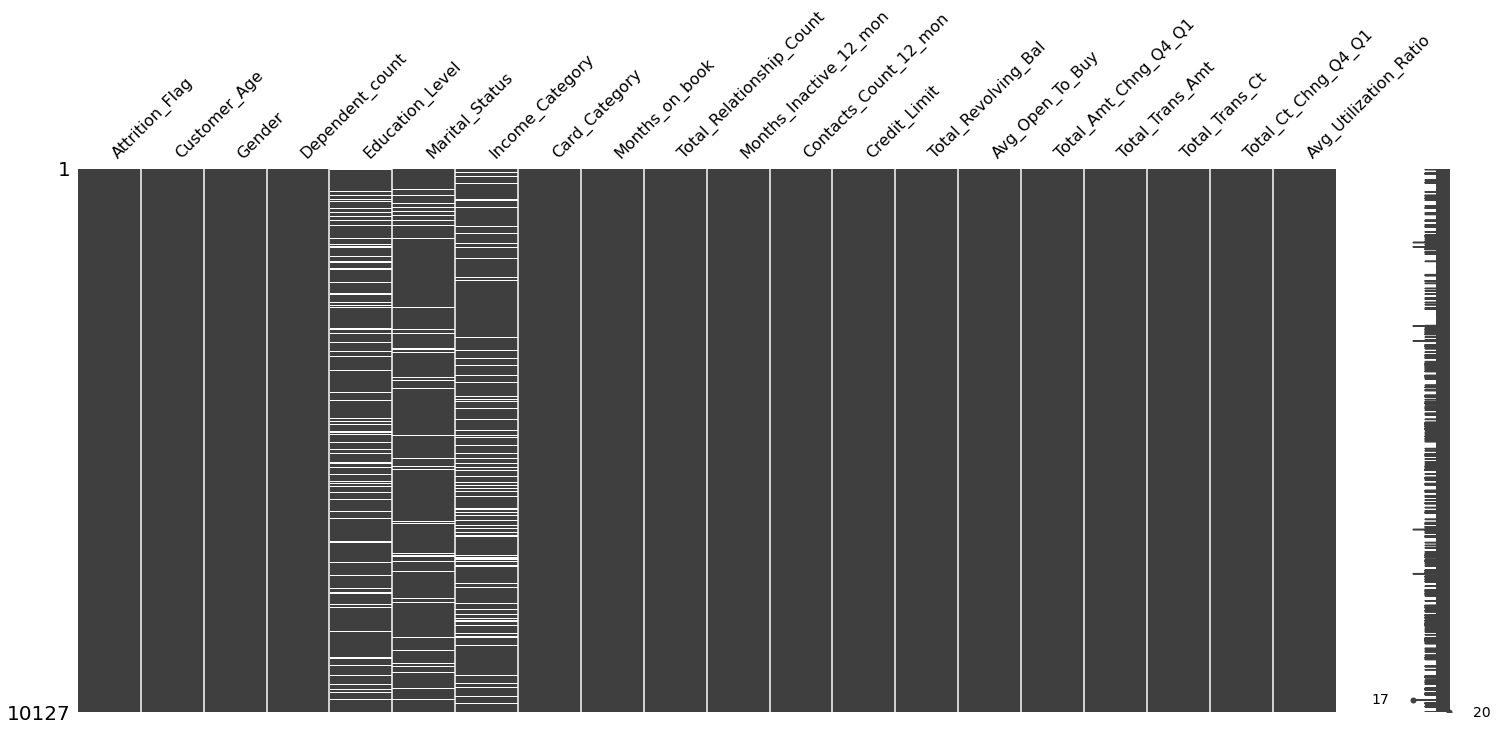

In [152]:
# Primero rellenaremos los registros que tienen ese valor con NaNs.
mask = data != 'Unknown'
data = data[mask]
print(data.isna().sum()[data.isna().sum() != 0])

msno.matrix(data)

Ahora procederemos a inputar esos valores.

Para imputar los valores faltantes lo que haremos sera predecirlos. Crearemos un modelo de Random Forest que predecira la variable que yo quiero imputar.

Para esto utilizaremos todos los registros que <b>NO</b> son nulos como nuestros datos de entrenamiento y los registros que tienen nulos los usaremos como datos para predecir la variable target.

Fitearemos varios modelos considerando todas las variables que no tengan registros nulos. Por lo tanto aqui consideraremos como features a todas las variables a excepcion de 'Education_Level', 'Marital_Status' e 'Income_Category'.

Como variable target a las que no incluimos ('Education_Level', 'Marital_Status' e 'Income_Category'). Por lo tanto plantearemos tres modelos de prediccion.

Para realizar esta tarea creamos la siguiente funcion.

In [153]:
data.isnull().sum()[data.isnull().sum() > 0].index.tolist()

['Education_Level', 'Marital_Status', 'Income_Category']

In [154]:
# Funcion para predecir e imputar los registros nulos.
def prediction_imputation (df, variable_imputar):
    # --- PREPARACION DE DATOS---
    # Primero obtengo el nombre de las columnas que tienen nulos.
    mask_null = df.isnull().sum() > 0
    null_cols = df.isnull().sum()[mask_null].index.tolist()
    
    # Obtengo mi Dataframe sin nulos, el cual usare para entrenar el modelo.
    df_no_nulls = df.dropna().reset_index(drop=True)
    
    # Creo una lista con el nombre de variables categoricas que se encuentran en X_fun
    # ya que eliminamos las que tenian nulos.
    cat_cols_incluidas = [] 
    # Recorro mis columnas categoricas del dataframe original.
    for i in cat_cols:
        # Si la columna no se encuentra en las que presentan valores nulos.
        if i not in null_cols:
            # Considero esta columna.
            cat_cols_incluidas.append(i)
    
    # Declaro mis features y mi variable target.
    # Dropeo las columnas que contienen nulos.
    X_fun = df_no_nulls.drop(columns=null_cols)
    y_fun = df_no_nulls[variable_imputar]
    
    # Obtengo las variables que voy a usar para predecir los valores a imputar
    # estas variables se corresponen con los registros nulos de la columna a imputar.
    mask_target_null = df[variable_imputar].isnull()
    
    X_prediction = df.loc[mask_target_null, :].drop(columns=null_cols)
    
    # ---ESCALADO DE DATOS---
    # Instancio el escalador.
    scaler = StandardScaler()
    
    # Escalo las variables numericas.
    X_fun_num_sc = pd.DataFrame(data=scaler.fit_transform(X_fun[num_cols]), columns=X_fun[num_cols].columns, index=X_fun[num_cols].index)
    
    # Concateno las variables escaladas con mis columnas categoricas.
    X_fun = pd.concat([X_fun['Attrition_Flag'], X_fun[cat_cols_incluidas], X_fun_num_sc], axis=1)
    
    # Transformo las variables numericas de mi dataframe que voy a usar para predecir.
    X_prediction_num_sc = pd.DataFrame(data=scaler.transform(X_prediction[num_cols]), columns=X_prediction[num_cols].columns, index=X_prediction[num_cols].index)
    
    # Concateno las variables escaladas con las columnas categoricas.
    X_prediction = pd.concat([X_prediction['Attrition_Flag'], X_prediction[cat_cols_incluidas], X_prediction_num_sc], axis=1)
    
    
    # ---RESAMPLEO CLASE DESBALANCEADA---
    # Ya que la clase target se encuentra desbalanceada procedo a balancearla mediante SMOTENC.
    # Para eso debo pasarle a SMOTENC el indice de las columnas categoricas.
    cat_col_num = []
    # Obtengo la posicion de mis variables categoricas
    # Recorro las columnas de mi Dataframe de entrenamiento.
    for i in range(len(X_fun.columns)):
        # me fijo si el nombre de la columna coincide con algun nombre de la lista de las variables categoricas.
        if X_fun.columns[i] not in num_cols:
            # Agrego el valor de i (se corresponde con la posicion de la columna) a la lista.
            cat_col_num.append(i)
    
    # Instancio SMOTENC
    sm = SMOTENC(categorical_features=cat_col_num, sampling_strategy='minority', random_state=13)
    
    X_fun, y_fun = sm.fit_resample(X_fun, y_fun)
    
    
    # ---DUMIFICO VARIABLES DUMMIES---
    X_fun = pd.get_dummies(X_fun, columns=cat_cols_incluidas, drop_first=True)
    
    X_prediction = pd.get_dummies(X_prediction, columns=cat_cols_incluidas, drop_first=True)
    
    
    # ---PREDIGO CON MODELO RANDOMFOREST---
    # Instancio el modelo.
    rf = RandomForestClassifier()
    
    # Fiteo el modelo.
    rf.fit(X_fun, y_fun)
    
    # Predigo mi clase a imputar.
    target_prediction = rf.predict(X_prediction)
    
    # Creo un Dataframe para poder imputar datos.
    # El indice de 'X_prediction' se corresponde con los valores nulos.
    df_imputar = pd.DataFrame(data=target_prediction, index=X_prediction.index)
    
    df.loc[mask_target_null, variable_imputar] = df_imputar[0]

Procedo a imputar mis valores nulos de las columnas.

In [155]:
prediction_imputation(data,'Education_Level')
prediction_imputation(data,'Marital_Status')
prediction_imputation(data,'Income_Category')

Series([], dtype: int64)


<AxesSubplot:>

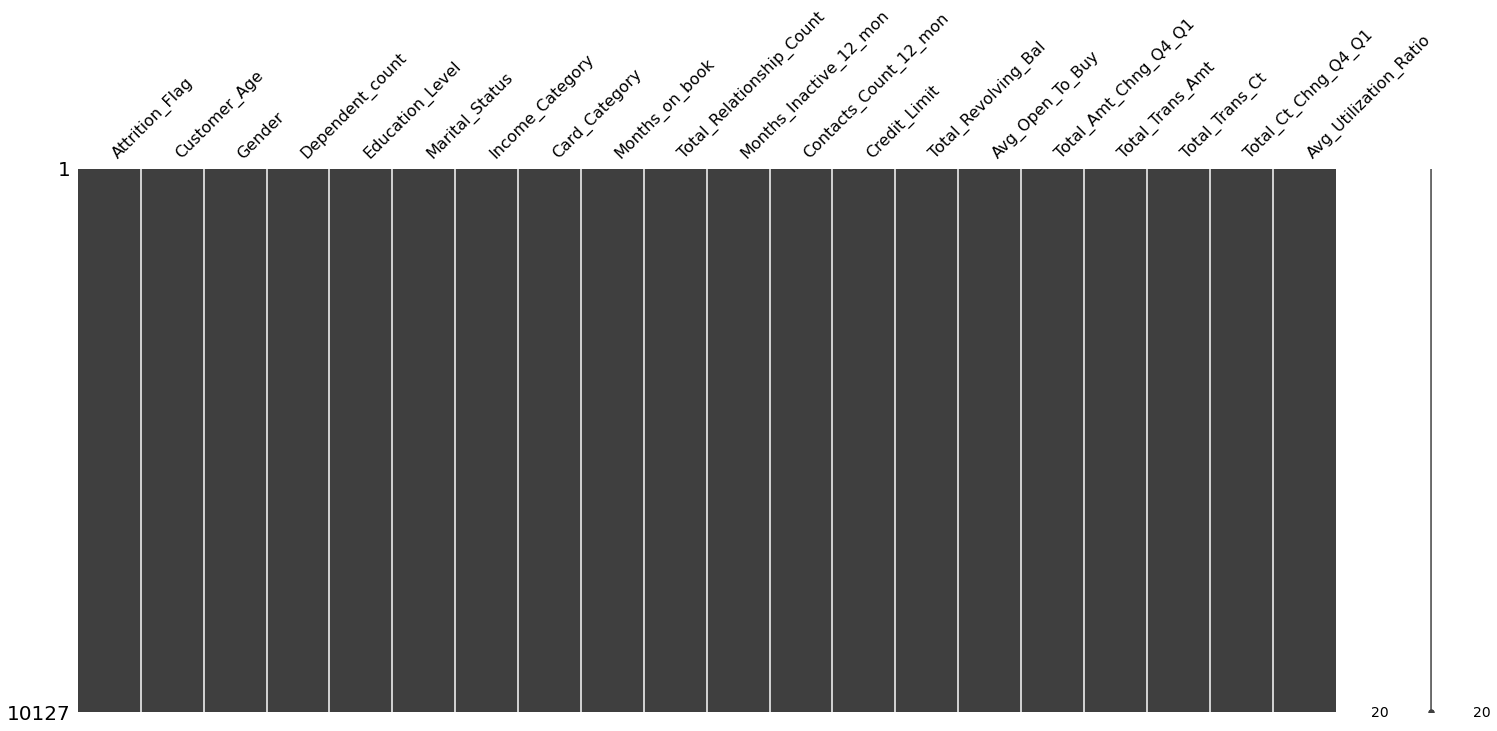

In [156]:
print(data.isna().sum()[data.isna().sum() != 0])

msno.matrix(data)

In [157]:
def filtrar_outliers(df,num_cols):
    # Contador de elementos antes de filtrar.
    elementos_inicio = df.shape[0]
    
    # Obtengo los Zscores de mis variables numericas.
    z_scores = zscore(df[num_cols])
    
    # Aplico el valor absoluto a los Zscores, para que todos los valores sean positivos.
    abs_z_scores = np.abs(z_scores)
    
    # Filtro mis valores y me quedo con los menores a 3.
    entradas_filtradas = (abs_z_scores<3).all(axis=1)
    df = df[entradas_filtradas]
    
    df.reset_index(inplace=True, drop=True)
    
    # Contador de elementos despues de filtrar.
    elementos_final = df.shape[0]
    elementos_eliminados = elementos_inicio - elementos_final
    
    print('Elementos iniciales', elementos_inicio)
    print('Elementos eliminados', elementos_eliminados)
    print('Elementos finales', elementos_final)
     
    return df

data = filtrar_outliers(data,num_cols)

Elementos iniciales 10127
Elementos eliminados 814
Elementos finales 9313


Nos fijamos como quedo el balance de la clase target.

In [158]:
data['Attrition_Flag'].value_counts(normalize=True)

0    0.834962
1    0.165038
Name: Attrition_Flag, dtype: float64

In [159]:
data['Attrition_Flag'].value_counts(normalize=False)

0    7776
1    1537
Name: Attrition_Flag, dtype: int64

In [160]:
data.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0               0            44      M                2        Graduate   
1               0            42      M                5      Uneducated   
2               0            57      F                2        Graduate   
3               0            45      F                2        Graduate   
4               0            47      M                1       Doctorate   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $40K - $60K          Blue              36   
1        Married         $120K +          Blue              31   
2        Married  Less than $40K          Blue              48   
3        Married     $40K - $60K          Blue              37   
4       Divorced     $60K - $80K          Blue              42   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         3                       1                      2   
1                         5                       3                      2   
2                         5                       2                      2   
3                         6                       1                      2   
4                         5                       2                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0        4010.0                 1247           2763.0                 1.376   
1        6748.0                 1467           5281.0                 0.831   
2        2436.0                  680           1756.0                 1.190   
3       14470.0                 1157          13313.0                 0.966   
4       20979.0                 1800          19179.0                 0.906   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1088              24                0.846                  0.311  
1             1201              42                0.680                  0.217  
2             1570              29                0.611                  0.279  
3             1207              21                0.909                  0.080  
4             1178              27                0.929                  0.086

# Analisis y distribucion de las variables.

In [161]:
# Ploteo todas mis columnas numericas.
for i in num_cols:
    fig = make_subplots(rows=1, cols=2)
    
    tr1 = go.Box(y=data[i], name= 'Box Plot')
    
    values_0 = data.query('Attrition_Flag==0')[i]
    tr2 = go.Histogram(x=values_0, name = 'Permanece')
    
    values_1 = data.query('Attrition_Flag==1')[i]
    tr3 = go.Histogram(x=values_1, name = 'Abandono')

    fig.add_trace(tr1,row=1, col=1)
    fig.add_trace(tr2,row=1, col=2)
    fig.add_trace(tr3,row=1, col=2)
    
    fig.update_layout(height=500, width=1200, title_text='Distribucion: '+i, barmode='stack')
    fig.show()

Se puede observar la presencia de outliers, pero eso no nos importa ya que la idea de haber aplicado z_scores es no eliminar registros en cantidad y perder informacion que seria importante, por lo tanto esos outlers, no se le prestara atencion.

Ahora veremos como se distribuyen las columnas caregoricas.

In [162]:
for i in cat_cols:
    specs = [[{'type':'histogram','rowspan':2}, {'type':'pie'}],
             [None, {'type':'pie'}]]
    fig = make_subplots(rows=2, cols=2,specs=specs, subplot_titles=('','<b>Permanece en el banco<b>', '<b>Abandona el banco<b>'))
    
    # Ploteo mi histograma de la variable categorica i.
    tr1 = go.Histogram(x=data[i], name = i +  ' Histograma')
    
    # Query es como usar una mascara.
    # Me quedo con los clientes que se quedan en el banco.
    # Del value_counts me quedo con los valores.
    value_0 = data.query('Attrition_Flag==0')[i].value_counts().values
    
    # Del value_counts me quedo conlos indices (etiquetas).
    labels_0 = data.query('Attrition_Flag==0')[i].value_counts().index.tolist()
    
    # Ploteo grafico dona de los clientes que permanecen en el banco.
    tr2 = go.Pie(values=value_0, labels=labels_0, hole=0.4, name= 'Permanece')
    
    # Clientes que abandonan el banco.
    value_1 = data.query('Attrition_Flag==1')[i].value_counts().values
    labels_1 = data.query('Attrition_Flag==1')[i].value_counts().index
    
    tr3 = go.Pie(values=value_1, labels=labels_1, hole=0.4, name='Abandona')
    
    fig.add_trace(tr1, row=1, col=1)
    fig.add_trace(tr2, row=1, col=2)
    fig.add_trace(tr3, row=2, col=2)
    
    fig.update_layout(height=650, width=1000, title_text='Distribucion: '+i)
    fig.show()

Al ver los graficos de las variables categoricas no podemos notar alguna tendencia de los datos, a simple vista, para poder interpretar por que un cliente abandonaria el banco o no.

No podemos observar diferencias entre los clientes que abandonan el banco y los que permanecen en el mismo. Creemos que esto puede deberse al desbalance de la clase target.

# Implementacion de modelos

Ahora comenzaremos a aplicar distintos modelos y tecnicas y procederemos a comparar las metricas.

Comenzaremos creando una funcion para obtener las metricas de los modelos, tanto en train como en test, y ademas un heatmap de la matriz de confusion.

In [163]:
# Funcion para mostrar metricas.
def model_metrics(y_train, y_pred_train, y_pred_train_proba, y_test, y_pred_test, y_pred_test_proba, plot_conf_mat=True):
    
    # ---METRICAS TRAIN---
    # Matriz de confusion con mis datos de entrenamiento.
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)
    
    # Obtengo los TN, FP, FN, TP de la matriz de confusion de entrenamiento.
    tn_train, fp_train, fn_train, tp_train = conf_matrix_train.ravel()
    
    # Obtengo metricas de train.
    acc_score_train = np.round(accuracy_score(y_train, y_pred_train),4)
    rec_score_train = np.round(recall_score(y_train, y_pred_train),4)
    prec_score_train = np.round(precision_score(y_train, y_pred_train),4)
    spec_score_train= np.round((tn_train / (tn_train + fp_train)),4)
    f_score_train = np.round(f1_score(y_train, y_pred_train),4)
    
    fpr_log_train, tpr_log_train, thr_log_train = roc_curve(y_train, y_pred_train_proba[:,1])
    auc_score_train = np.round(auc(fpr_log_train, tpr_log_train),4)
    
    # ---METRICAS TEST---
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    
    tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
    
    acc_score_test = np.round(accuracy_score(y_test, y_pred_test),4)
    rec_score_test = np.round(recall_score(y_test, y_pred_test),4)
    prec_score_test = np.round(precision_score(y_test, y_pred_test),4)
    spec_score_test= np.round((tn_test / (tn_test + fp_test)),4)
    f_score_test = np.round(f1_score(y_test, y_pred_test),4)
    
    fpr_log_test, tpr_log_test, thr_log_test = roc_curve(y_test, y_pred_test_proba[:,1])
    auc_score_test = np.round(auc(fpr_log_test, tpr_log_test),4)
    
    # Creo 2 filas, uno con los datos de train, otra con los datos de test. Y 5 columnas para las metricas.
    data_df = [
            [acc_score_train, rec_score_train, prec_score_train, spec_score_train, f_score_train, auc_score_train],
            [acc_score_test,  rec_score_test,  prec_score_test,  spec_score_test,  f_score_test,  auc_score_test]
            ]
    
    # Le doy nombre a las columnas.
    columns_df = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1-Score', 'AUC']

    # Creo DataFrame.
    data_result = pd.DataFrame(data_df, columns=columns_df, index=['Metricas Train', 'Metricas Test'])
    
    # Si se indica como algumento de la funcion, plotea la matriz de confusion.
    if plot_conf_mat:
        sns.heatmap(conf_matrix_test, annot=True, fmt='d', cbar=False, cmap="YlGnBu")
        plt.xlabel('Valores Predichos')
        plt.ylabel('Valores Reales')
    
    # Devuelvo el DataFrame con las metricas.
    return data_result

In [164]:
# Funcion para graficar las curvas ROC de los modelos que se le pasa.
# Recibe una lista de modelos = [ [y_test, y_test_probas, nombre de la etiqueta en el grafico], [x,x,x] ]
def roc_curves (values=list):
    
    # Inicio un DataFrame vacio.
    data_fun = pd.DataFrame(columns=['tpr', 'fpr', 'Modelo'])
    
    # Recorro los distintos modelos.
    for i in values:
        # Indice 0 corresponde a y_test.
        y_test_fun = i[0]
        
        # Indice 1 corresponde a y_pred_proba.
        y_pred_probas_fun = i[1]
        
        # Indice 2 a etiqueta en el grafico.
        label = i[2]
        
        # Obtengo el False Positie Rate (fpr) y True Positive Rate (tpr) de la funcion.
        fpr, tpr, thr = roc_curve(y_test_fun, y_pred_probas_fun[:,1])

        # Creo un DataFrame para almacenar datos en una vuelta del loop.
        loop_df = pd.DataFrame({'tpr' : tpr, 'fpr' : fpr, 'Modelo' : label})
        
        # Agrego los datos de la vuelta del loop al DataFrame de la funcion.
        data_fun = pd.concat([data_fun, loop_df], ignore_index=True)
    
    # Grafico los distintos modelos.    
    fig = px.line(data_fun, x='fpr', y='tpr', color='Modelo')
    fig.update_layout(height=650, width=1000)
    fig.show()

### Modelo Base

Plantearemos tres modelos de ensable los cuales los iremos comparando a la vez. Un modelo de bagging (Random Forest) y dos modelos de boosting (Ada boost y XGboost). Y veremos como performan los distintos modelos frente a las distintas tecnicas que le iremos aplicando al dataset.

Claramente como se nos enseño esperamos que el modelo que mejor performe en todos los casos sea el de XGBoost.

La idea del bagging es crear muchos subsets de los datos de entrenamiento, con reposicion. Cada observacion tiene las mismas chances de ser seleccionada como muestra, luego cada muestra de entrenamiento es usada para entrenar un unico modelo de arbol de decision, generando tantos arboles como muestras se tengan. El resultado sera un ensamble que tomara una decision por voto mayoritario.

En cuanto a boosting, es un procedimiento iterativo que va construyendo un modelo final en pasos. En cada paso aprendera de los errores cometidos en los pasos previos. Se entrena una secuencia de modelos donde se da mas peso a los ejemplos que fueron clasificados erroneamente por iteraciones anteriores (trabaja sobre los errores del modelo anterior o bien usandolos para cambiar la ponderacion en el siguiente modelo).

Para aplicar los modelos descriptos anteriormente crearemos tres funciones, una para cada modelo de ensamble.




In [165]:
# Modelo de Random Forest.
# Toma features ya escaladas.
def RandomForest_model (X_train, X_test, y_train, y_test, plot_conf_mat=True, balance_target=None):
    # Instancio el modelo y seteo hiperparametros.
    model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=13, class_weight=balance_target)

    # Fiteo modelo.
    model.fit(X_train, y_train)
    
    # Predigo con mis datos de entrenamiento, para metricas de train.
    y_pred_train = model.predict(X_train)
    y_pred_train_proba = model.predict_proba(X_train)
    
    # Predigo con mis datos de test, para metricas de test.
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Ejecuto la funcion de metricas, guardo el dataframe de resultado.
    data_resultado = model_metrics(y_train, y_pred_train, y_pred_train_proba, y_test, y_pred, y_pred_proba, plot_conf_mat=plot_conf_mat)
    
    # Devuelvo el dataframe resultado y las predicciones de probabilida para utilizar en la funcion de la curva ROC.
    return data_resultado, y_pred_proba


In [166]:
# Modelo AdaBoost
def AdaBoost_model (X_train, X_test, y_train, y_test, plot_conf_mat=True): 
    # Instancio el modelo y seteo hiperparametros.
    model = AdaBoostClassifier(n_estimators=100, random_state=13)

    # Fiteo modelo.
    model.fit(X_train, y_train)
    
    # Predigo con mis datos de entrenamiento, para metricas de train.
    y_pred_train = model.predict(X_train)
    y_pred_train_proba = model.predict_proba(X_train)
    
    # Predigo con mis datos de test, para metricas de test.
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Ejecuto la funcion de metricas, guardo el dataframe de resultado.
    data_resultado = model_metrics(y_train, y_pred_train, y_pred_train_proba, y_test, y_pred, y_pred_proba, plot_conf_mat=plot_conf_mat)

    # Devuelvo el dataframe resultado y las predicciones de probabilida para utilizar en la funcion de la curva ROC.
    return data_resultado, y_pred_proba

In [167]:
# Modelo XGBoost.
def xgboost_model (X_train, X_test, y_train, y_test, plot_conf_mat=True):
    # Instancio el modelo y seteo hiperparametros.
    model = XGBClassifier(n_estimators=100, max_depth=5,verbosity=0, random_state=13)

    # Fiteo modelo.
    model.fit(X_train, y_train)
    
    # Predigo con mis datos de entrenamiento, para metricas de train.
    y_pred_train = model.predict(X_train)
    y_pred_train_proba = model.predict_proba(X_train)
    
    # Predigo con mis datos de test, para metricas de test.
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Ejecuto la funcion de metricas, guardo el dataframe de resultado.
    data_resultado = model_metrics(y_train, y_pred_train, y_pred_train_proba, y_test, y_pred, y_pred_proba, plot_conf_mat=plot_conf_mat)
    
    # Devuelvo el dataframe resultado y las predicciones de probabilida para utilizar en la funcion de la curva ROC.
    return data_resultado, y_pred_proba

#### Dumificacion de variables

Una vez que tenemos definidas las funciones a utilizar, preparemos los datos para poder entrenar el modelo, como se trata del modelo base, lo unico que haremos sera dumificar las variables y entrenar el modelo, en esta instancia no nos esta importando el balance de la clase target.

In [168]:
# Creo un DataFrame con mis variables dummificadas.
data_dummie = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# Declaro mis features para mi modelo base.
X_base = data_dummie.drop(columns='Attrition_Flag')

# Declaro mi variable para mi modelo base.
y_base = data_dummie['Attrition_Flag']

# Separo en datos de train y test
X_train_base , X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, stratify=y_base, random_state=13)

# Escalo los datos.
scaler = StandardScaler()
X_train_base_sc = scaler.fit_transform(X_train_base)
X_test_base_sc = scaler.transform(X_test_base)

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9190  0.5473     0.9348       0.9925    0.6904  0.9738
Metricas Test     0.9163  0.5260     0.9395       0.9933    0.6745  0.9643

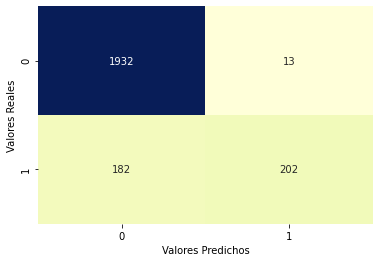

In [169]:
rf_metrics_base, rf_pred_proba_base = RandomForest_model(X_train_base_sc, X_test_base_sc, y_train_base, y_test_base)
rf_metrics_base

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9666  0.8786     0.9159       0.9841    0.8969  0.9924
Metricas Test     0.9614  0.8438     0.9153       0.9846    0.8780  0.9872

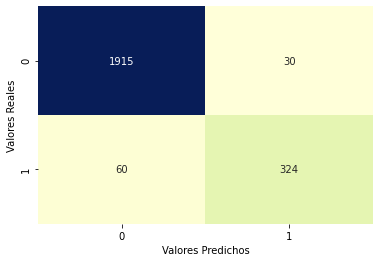

In [170]:
adab_metrics, adab_pred_proba = AdaBoost_model(X_train_base_sc, X_test_base_sc, y_train_base, y_test_base)
adab_metrics

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    1.0000  1.0000     1.0000       1.0000    1.0000  1.0000
Metricas Test     0.9725  0.8932     0.9372       0.9882    0.9147  0.9933

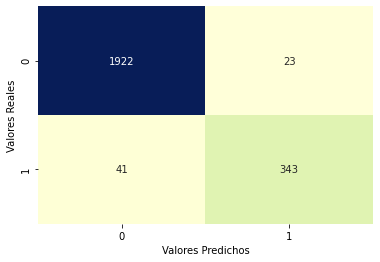

In [171]:
xgb_metrics, xgb_pred_proba = xgboost_model(X_train_base_sc, X_test_base_sc, y_train_base, y_test_base)
xgb_metrics

A simplevista, tanto en las metricas y en la matriz de confusion puede verse la superioridad del modelo XGBoost, seguido por el modelo AdaBoost y en ultimo lugar el modelo de RandomForest.

Puede verse que el modelo de RandomForest no fue bueno detectando los casos positivos, esto se ve reflejado en la metrica de recall, la cual mide la proporcion de positivos correctamente predicha. Esto tiene sentido ya que la clase target esta altamente desbalanceada y el modelo de RandomForest predice correctamente a la clase mayoritaria, podemos ver lo deducido al ver el valor del specificity score, el cual mide que tan especifico es el clasificador al predecir instancias negativas.

OBS: ya que la ocurrencia de falsos negativos es inaceptable nuestro modelo (nos interesa predecir que cliente abandonara el banco para poder ofrecerle algun tipo de beneficio), el score que mas nos interesara sera el Recall. A su vez se buscara que el valor de la metrica F1 y AUC sean lo mas elevadas posibles lo que indicara que el modelo que elegimos sea el mas optimo.

NOTA: Ya que los modelos de AdaBoost y XGBoost performaron muy bien no los tendremos en cuenta para aplicar y comparar las distintas tecnicas que le aplicaremos al dataset, nos concentraremos en mejorar el modelo de Random Forest para que el mismo performe igual o mejor que los modelos mencionados.

Compararemos ahora los tres modelos bases mediante la curva ROC.

In [172]:
modelos = [[y_test_base, rf_pred_proba_base, 'Random Forest'],
           [y_test_base, adab_pred_proba, 'AdaBoost'],
           [y_test_base, xgb_pred_proba, 'XGBoost']]

roc_curves(values=modelos)

Puede apreciarse la diferencia entre los tres modelos al observar la curva ROC de cada uno de los modelos. podemos apreciar que el modelo XGBoost se encuentra mas cerca del modelo perfecto.

### Balanceo de clases

Ahora procederemos a solucionar el desbalance de la clase target, para esto propondremos tres tecnicas:
- Oversampling, aumentando los casos de la clase minoritaria, mediante SMOTENC (no usamos SMOTE ya que el dataset tiene variables continuas y categoricas), este algoritmo genera muestras simuladas de la clase minoritaria.
- Undersampling, descartando casos de la clase mayoritaria, mediante la clase RandomUnderSampler, la cual toma observaciones de la clase mayoritaria al azar, con o sin reposicion.
- Class Weighting, equilibra la clase minoritaria dandole un peso mayor, esta tecnica se encuentra como hiperparametro en muchos de los algoritmos de machine learning. El modelo de RandomForest cuenta con este hiperparametro.

Antes de aplicar estas tecnicas debemos preparar el dataset, primero separar el dataset en datos de train y datos de test.

In [173]:
# Declaro mis features para balanceo de clases.
X = data.drop(columns='Attrition_Flag')

# Declaro mi variable target para balanceo de clases.
y = data['Attrition_Flag']

# Separo en datos de entrenamiento y testeo.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=13)

Ya que para hacer oversample vamos a usar SMOTENC, el cual genera muestras mediante un algoritmo KNN (utiliza la distancia euclideana para generar las muestras), voy a necesitar que el dataset este normalizado previamente.

Para eso normalizaremos previamente mis variables para asi aplicar SMOTENC.

Luego debemos identificar las variables categoricas como una lista con la posicion de cada feature en el dataset, para pasarsela como paramtetro a la clase de SMOTENC.

In [174]:
# Utilizo ColumnTransformer para aplicar a mis variables continuas una Standarizacion.
ct = ColumnTransformer([('pass', 'passthrough', make_column_selector(dtype_include=object)),
                        ('norm', StandardScaler(), make_column_selector(dtype_exclude=object))])

# Fiteo y transformo los datos de trin.
ct_array_train = ct.fit_transform(X_train)
# Creo un DataFrame con el array obtenido.
X_train = pd.DataFrame(data=ct_array_train, index=X_train.index)

# Creo una lista para recuperar el orden de mis variables.
cols_name = []
# Recupero primero por las columnas que ignoro que son las categoricas.
for i in ct.transformers_[0][2]:
    cols_name.append(i)
# Recupero luego las columnas continuas.
for i in ct.transformers_[1][2]:
    cols_name.append(i)
# Cambio de nombre a mis columnas
X_train.columns = cols_name
# Cambio tipo de datos
X_train[num_cols] = X_train[num_cols].astype('float64')

ct_array_test = ct.transform(X_test)
X_test = pd.DataFrame(data= ct_array_test, index=X_test.index)

# Cambio de nombre a mis columnas
X_test.columns = cols_name
# Cambio tipo de datos
X_test[num_cols] = X_test[num_cols].astype('float64')

# Lista vacia para almacenar el indice y nombre de las columnas categoricas.
cat_col_num = []

# Obtengo la posicion de mis variables categoricas
# Recorro las columnas de mi Dataframe de entrenamiento.
for i in range(len(X_train.columns)):

    # me fijo si el nombre de la columna coincide con algun nombre de la lista de las variables categoricas.
    if X_train.columns[i] not in num_cols:
        # Agrego el valor de i (se corresponde con la posicion de la columna) a la lista.
        cat_col_num.append(i)
        
print('Numero de columna de variables categoricas:', cat_col_num)

Numero de columna de variables categoricas: [0, 1, 2, 3, 4]


#### Oversampling (SMOTENC)

Ahora aplicaremos el algoritmo de SMOTENC y luego dumificaremos las variables de la matriz de features.

In [175]:
# Instancio el modelo de Oversample.
sm = SMOTENC(categorical_features=cat_col_num, sampling_strategy='minority', random_state=13)

# Resampleo mis Datos de Train.
X_train_overs,y_train_overs = sm.fit_resample(X_train, y_train)

# Para mejor interpretacion.
y_test_overs = y_test

# Obtengo las variables dummies
X_train_overs = pd.get_dummies(X_train_overs, columns=cat_cols, drop_first=True)
X_test_overs = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

Balance de clases antes de aplicar SMOTENC

In [176]:
print(y_train.value_counts())

0    5831
1    1153
Name: Attrition_Flag, dtype: int64


Balance de clases luego de aplicar SMOTENC

In [177]:
print(y_train_overs.value_counts())

1    5831
0    5831
Name: Attrition_Flag, dtype: int64


Ahora evaluaremos los distintos modelos

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9303  0.9295     0.9310       0.9311    0.9302  0.9826
Metricas Test     0.9141  0.8333     0.7018       0.9301    0.7619  0.9638

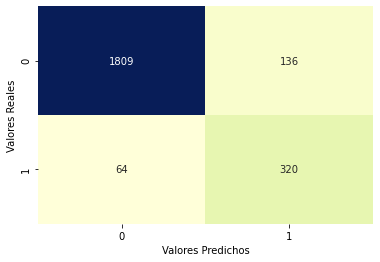

In [178]:
rf_metrics_overs, rf_pred_proba_overs = RandomForest_model(X_train_overs, X_test_overs ,y_train_overs, y_test_overs)
rf_metrics_overs

Podemos ver que la performance de RandomForest mejoro bastante y ya no se encuentra tan lejos de la performance que tiene AdaBoost y XGBoost.

Algo para mencionar, al observar los scores de Recall, Precision y F1 podemos ver que hay una diferencia entre los valores de las metricas en train y las metricas en test, esto inficaria que el modelo tiene una alta varianza y me produce overfitting, creemos que se puede deber a la presencia de outliers.

Puede verse que este modelo fue el mas balanceado, podemos notar eso al comparar la matriz de confusion o al ver el valor de F1 (Esta metrica es una medida armonica entre el Recall y precision) el cual fue el mas elevado (no por mucho) de los tres modelos.

El valor de la metrica Recall no es el mas elevado, lo que significa que no es el mejor de los modelos para detectar las instancias positivas, pero mirando la metrica de Specificity vemos que el modelo predice bien las instancias positivas y por eso no hay una presencia elevada de falsos positivos, como es el caso del modelo de Undersample.

El modelo de Oversample es el modelo mas equilibrado de las tres tecnicas implementadas, esto lo podemos observar al ver el valor de la metrica F1, la cual es la mas elevada de todos los modelos.

#### Undersampling

Haremos un <b>Undersampling</b>, descartando casos de la clase mayoritaria. Para esto usaremos la clase RandomUnderSampler, la cual samplea observaciones de la clase mayoritaria al azar con o sin reposicion.

Aqui instanciamos la clase y luego resampleamos mis datos de entrenamiento. Luego dumificaremos mi matriz de features nuevamente.

In [179]:
# Instancio el modelo de Undersampling.
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=20)

# Resampleo mis datos de entrenamiento.
X_train_unders, y_train_unders = undersampler.fit_resample(X_train, y_train)

# Mejor interpretabilidad.
X_test_unders = X_test_overs
y_test_unders = y_test

# Obtengo mis variables dummie.
X_train_unders = pd.get_dummies(X_train_unders, columns=cat_cols, drop_first=True)


Balance de clases luego de aplicar RandomUnderSampler.

In [180]:
print(y_train_unders.value_counts())

1    1153
0    1153
Name: Attrition_Flag, dtype: int64


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9206  0.9271     0.9152       0.9141    0.9212  0.9767
Metricas Test     0.9034  0.8802     0.6538       0.9080    0.7503  0.9609

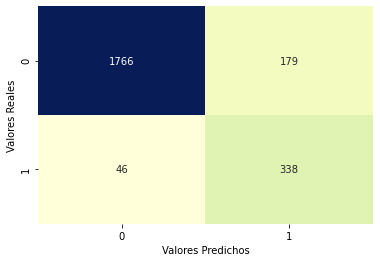

In [181]:
rf_metrics_unders, rf_pred_proba_unders = RandomForest_model(X_train_unders, X_test_unders ,y_train_unders, y_test_unders)
rf_metrics_unders

Puede verse que en este modelo sigue apareciendo la alta varianza que mencionamos previamente.

Ademas al ver la matriz de confusion podemos decr que este modelo fue el mejor de todos prediciendo las instancias positivas del dataset, pero tuvo un numero mayor de falsos postivos que los otros dos modelos. Esto se ve reflejado en la metrica de Presicion, la cual es un poco menor que el modelo de oversample.

En cuanto al accuracy, no logro el mismo valor que el modelo de Oversample pero si que el modelo de Class Weighting, lo que indica una menor proporcion de clases correctamente predichas.

El modelo de unsersample es el mejor modelo para predecir las instancias positivas del dataset. Puede observarse en el valor del recall el cual es el mas elevado de todos los modelos.

#### Modelo de "Class Weighting"

A este modelo le aplicaremos el mismo modelo que al anterior pero con la salvedad de que utilizaremos el hiperparametro "class_weight='balanced'", asi de esa manera corregiremos el desbalance de la clase target mediante otra tecnica ademas de las ya mencionadas.

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9072  0.9228     0.6556       0.9041    0.7666  0.9753
Metricas Test     0.8987  0.8932     0.6375       0.8997    0.7440  0.9643

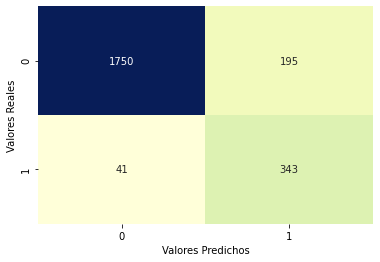

In [182]:
rf_metrics_cw, rf_pred_proba_cw = RandomForest_model(X_train_base_sc, X_test_base_sc ,y_train_base, y_test_base, balance_target='balanced')
rf_metrics_cw

Puede verse que este modelo performo muy similar al modelo que se le aplico la tecnica de Oversample, con la diferencia de que no se logra apreciar una alta varianza, ya que la diferencia entre las metricas de train y de test no es tan grande como en el modelo anterior.

Podemos ver que si bien la metricas de test se parecen mucho a las de mis otros modelos, las metricas de train son menores que las que lograron los mismos. Esta disminucion en las metricas de train estaria indicando que el modelo bajo la varianza a costa del incremento del sesgo, lo que me estaria induciendo un leve underfitting.

Por lo tanto al aplicar la tecnica de Class Weighting pudimos mejorar notablemente la varianza del modelo, pero aumentamos el sego en una pequeña medida.

In [183]:
modelos = [[y_test_overs, rf_pred_proba_overs, 'Random Forest Oversample'],
           [y_test_unders, rf_pred_proba_unders, 'Random Forest Undersample'],
           [y_test_base, rf_pred_proba_cw, 'Random Forest Class Weighting'],
           [y_test_base, rf_pred_proba_base, 'Random Forest Base']]

roc_curves(values=modelos)

Aqui no se puede notar diferencia alguna entre los distintos modelos.

Al hacer zoom en el codo de la curva ROC, podemos ver que el modelo de Class Weighting es el que mas alejado se encuentra del modelo perfecto, pero la diferencia es minima.

Ahora Trataremos de reducir la varianza del modelo mediante feature importance, feature selection y feature extraction.

## Feature Importance

La importancia compara la medida de impureza antes y despues de la particion. A mayor ganancia, mas importancia, ya que si la medida de impureza del nodo padre es mayor a la suma de las impurezas de los hijos, mejoramos la pureza.

Conocer las features mas importantes nos ayuda a generar un <u>arbol mas eficiente</u>, en terminos de computos, permitiendo reducir el conjunto de features en uno menor que genera un modelo de bajo o nulo costo en la performance.

Para calcular la feature importance usaremos el metodo que viene en el algoritmo de Random Forest, para esto generaremos una funcion.

Esta funcion tomara los datos de train y test, fiteara un modelo de Randomforest y luego obtendra la importancia de las features. Una vez obtenida las features ordenadas segun su orden de importancia la funcion evaluara, agregando de a una variable a la vez (segun su orden de importancia) un modelo de RandomForest de donde se obtendra la metrica F1 para train y test, para poder ser comparada, asi de esa manera sabremos con cuales variables quedarnos.

Esta Funcion me devolvera:
- Un grafico con las features ordenadas segun su importancia.
- Un grafico con la variacion del F1-Score de train y test donde podremos ver cual fue el modelo que mejor performo
- Dos DataFrame con la features mas importantes, el primero corresponde a los datos de train y el segundo se correspnde a los datos de test, cada uno con las features que lograron el mayor score.

In [184]:
# Funcion para obtener las features mas importantes segun random forest.
# Esta funcion toma los datos divididos en Train y Test previamente normalizados.
def feature_importance_rf (X_train_fun, X_test_fun, y_train_fun, y_test_fun, plot_importancia=True, plot_variacion_f1=True):
    # Instancio el modelo y seteo hiperparametros.
    model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=13)

    # Fiteo modelo.
    model.fit(X_train_fun, y_train_fun)
    
    # Creo Dataframe con las features mas importantes
    df_importance = pd.DataFrame({'Variables' : X_train_fun.columns, 'Importancia' : model.feature_importances_})
    # Ordeno en orden descendente la importancia
    df_importance.sort_values('Importancia', ascending = False, inplace = True)
    # Reseteo el indice.
    df_importance.reset_index(inplace = True, drop=True)
    
    if plot_importancia:
        # Ploteo la importancia de las features
        fig = px.bar(df_importance, x = 'Variables', y = 'Importancia')
        fig.update_layout(height=500, width=1000,title = 'Importancia de variables segun Random Forest')
        fig.show()
    
    # Lista para guardar valores de F1-score de Train.
    f1_train = []
    # Lista para guardar valores de F1-Score de Test.
    f1_test = []
    # Lista para guardar las features que se utilizan en cada modelo, asi luego sera mas facil recuperarlas.
    features = []
    # Lista para poder graficar segun la cantidad de features que se incluyeron.
    cantidad_features = []
    
    # Creo lista en la que ire agregando de a una mis features, asi de esa manera agrego secuencialemente 
    # una feature a la vez.
    cols_incluir = []
    
    # Recorro las features, las cuales estan ordenadas segun orden de importancia.
    for i in df_importance['Variables']:

        # Agrego la columna que corresponde a la posicion del loop.
        cols_incluir.append(i)
        
        # Selecciono la feature a utilizar
        X_train_loop = X_train_fun[cols_incluir]
        X_test_loop = X_test_fun[cols_incluir]

        # Predigo con mi modelo RandomForest.
        data_resultado, y_pred_proba = RandomForest_model(X_train_loop, X_test_loop, y_train_fun, y_test_fun, plot_conf_mat=False)
        
        # Me quedo con el F1-Score de train y lo agrego a la lista.
        f1_train.append(data_resultado.loc['Metricas Train', 'F1-Score'])

        # Me qudo con el F1-Score de train y lo agrego a la lista.
        f1_test.append(data_resultado.loc['Metricas Test', 'F1-Score'])
        
        # Agrego a la lista, las columnas que uso el modelo del loop.
        features.append(X_train_loop.columns.tolist())
        
        # Agrego la cantidad de features que se utilizaron.
        cantidad_features.append(len(cols_incluir))
    
    # Creo DataFrame con todos los valores F1 para cada PC.    
    data_f1 = pd.DataFrame({'Cantidad_Features' : cantidad_features, 'F1-Train' : f1_train, 'F1-Test' : f1_test, 'Features' : features})

    # Obtengo el valor mas alto de F1-Score Test.
    data_test_max = data_f1.loc[data_f1['F1-Test'].idxmax(),['Cantidad_Features', 'F1-Test', 'Features']]
    
    if plot_variacion_f1:      
        # Creamos la figura para plotear.
        fig = go.Figure()
        # Agrego F1-Train al grafico.
        fig.add_trace(go.Scatter(x = data_f1['Cantidad_Features'], y = data_f1['F1-Train'], mode = 'lines+markers', name = 'F1-Score Train'))
        # Agrego F1-Test al grafico.
        fig.add_trace(go.Scatter(x = data_f1['Cantidad_Features'], y = data_f1['F1-Test'], mode = 'lines+markers', name = 'F1-Score Train'))

        fig.update_layout(height=500, width=1000,title = 'Variacion de F1-Score segun features seleccionadas', xaxis_title = 'Cantidad de features utilizadas', yaxis_title = 'F1-Score')
        fig.show()
        
        print('Mayor score logrado en Test:', data_test_max['F1-Test'],'- Utilizando las features', data_test_max['Features'])
    
    # Devuelvo dos Datasets, uno de Train y otro de Test.
    # Con las columnas que obtuvieron el maximo F1-Score Test.        
    return X_train_fun[data_test_max['Features']], X_test_fun[data_test_max['Features']]

### Modelo Oversampleado

Aplicaremos lo mencionado previamente a este modelo, para luego seleccionar las variables que creemos mas relevantes y luuego volver a calcular nuestro modelo.

In [185]:
X_train_feature_importance_overs, X_test_feature_importance_overs = feature_importance_rf(X_train_overs, X_test_overs, y_train_overs, y_test_overs)

Mayor score logrado en Test: 0.8141 - Utilizando las features ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Avg_Utilization_Ratio', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Amt_Chng_Q4_Q1']


Podemos ver como varia el grado de importancia de las features, no se puede observar un valor muy elevado, pero podemos ver como varia el F1-score al ir seleccionadndo las distitnas variables, y que en ciertos casos el F1-Score, dependiendo de las variables seleccionadas, mejora su valor respecto al modelo que solo se le aplico oversample.

Ahora veremos las demas metricas usando las variables seleccionadas por la funcion.

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9461   0.957     0.9366       0.9352    0.9466  0.9856
Metricas Test     0.9322   0.901     0.7425       0.9383    0.8141  0.9723

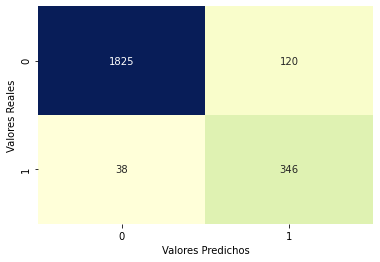

In [186]:
rf_metrics_overs_feature_importance, rf_pred_proba_overs_feature_importance = RandomForest_model(X_train_feature_importance_overs, X_test_feature_importance_overs, y_train_overs, y_test_overs)
rf_metrics_overs_feature_importance

Al comparar este modelo con el modelo al que solo se le aplico Oversample

<img src="img/modelo_rf_overs.png" width=30% height=25%> <b> Modelo R.F. Oversample </b>

Podemos notar inmediatamente al ver la matriz de confusion una mejora, esto se ve reflejado en las metricas de Train y Test, las cuales aumentaron sus valores. Se redujo considerablemente la cantidad de falsos positivos, los falsos negativos se redujeron tambien, pero en una menor medida.

Ademas puede verse que la diferencia entre los scores de Test y Train dismuinuyo notablemente, por lo que podemos decir que al implementear este metodo de Feature Importance, mejoramos el overfitteo del modelo.

Por lo tanto aplicar Feature importance mejoro la performance del modelo. 

### Modelo Undersampleado

In [187]:
X_train_feature_importance_unders, X_test_feature_importance_unders = feature_importance_rf(X_train_unders, X_test_unders, y_train_unders, y_test_unders)

Mayor score logrado en Test: 0.7964 - Utilizando las features ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Total_Amt_Chng_Q4_Q1', 'Total_Relationship_Count', 'Contacts_Count_12_mon', 'Credit_Limit']


Podemos notar en primera instancia que la difercia entre tomar distintas variables, no afecta de manera significativa al modelo a partir de incluir la variable 'Total_Relationship_Count', esto se puede apreciar al ver la variacion del F1-Score en Test.

Ademas podemos ver que el mayor score fue logrado tomando mayor cantidad de variables que el modelo de Oversample.

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9410  0.9480      0.935       0.9341    0.9414  0.9834
Metricas Test     0.9223  0.9219      0.701       0.9224    0.7964  0.9728

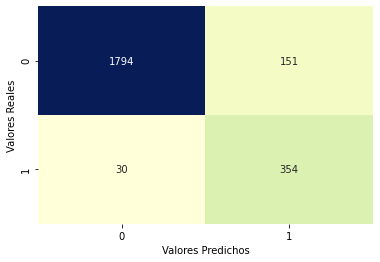

In [188]:
rf_metrics_unders_feature_importance, rf_pred_proba_unders_feature_importance = RandomForest_model(X_train_feature_importance_unders, X_test_feature_importance_unders, y_train_unders, y_test_unders)
rf_metrics_unders_feature_importance

Se puede ver que este modelo logro levemente un mayor valor de AUC que el modelo anterior, por lo tanto al observar la cura ROC veremos que este modelo se asemeja mas al modelo perfecto, pero al ver la matriz de confusion podemos ver que tuvo una mayor cantidad de falsos positivos, una tendencia que se viene repitiendo desde antes.

Lo dicho anteriormente se puede ver en la metrica de Recall, la cual es mas elevada que la anterior, esta indicando que este modelo es bueno detectando los verdaderos positivos sobre todos los casos positivos.

Al comparar este modelo con el que solo se le aplico undersample.

<img src="img/modelo_rf_unders.png" width=30% height=25%> <b> Modelo R.F. Undersample </b>

Podemos notar una disminucion en la cantidad de falsos positivos y negaticos. Por lo tanto podemos decir que este modelo mejoro la performance, no mejoro en igual medida el overfitteo que el modelo anterior.

De igual manera que el anterior, puede concluirse que aplicar Feature Importance mejora la performance del modelo.

Ahora compararemos estos modelos planteados mediante la curva AUC.


In [189]:
modelos = [[y_test_overs, rf_pred_proba_overs, 'R.F. Oversample'],
           [y_test_unders, rf_pred_proba_unders, 'R.F. Undersample'],
           [y_test_overs, rf_pred_proba_overs_feature_importance, 'R.F. Oversample - Feature Importance'],
           [y_test_unders, rf_pred_proba_unders_feature_importance, 'R.F. Undersample - Feature Importance']]

roc_curves(values=modelos)

Podemos ver como mencionamos se observa la clara diferencia entre modelos, los modelos a los que se le aplico Feature Importance se ajustan mejor al modelo perfecto que a los modelos que solo se le aplico un balance de clases.

Puede verse que la curva que mejor se ajusta la modelo perfecto es la que corresponde al modelo al cual se le aplico Undersample. Si bien obtuvo un mayor valor de AUC y una curva mejor, consideramos que las metricas del modelo de Oversample son mejores y mas equilibradas.

## Feature selection

Se dice asi al proceso de seleccionar un subset de las variables mas importantes del dataset, reteniendo la mayor cantidad de informacion posible.

Las razones por las que reducir la dimensionalidad del dataset son:
- Evitar o reducir Overfitting (nuestro caso).
- Predicciones y entrenamientos mas veloces.
- Modelos y datasets mas chicos.
- Darle mayor interpretabilidad al modelo.

Estaremos buscando eliminar features con baja varianza.

Ya que contamos con variables categoricas, no podremos usar VarianceThreshold, ya que calcula la importancia de la feature teniendo en cuenta la varianza. Por esa razon vamos a hacer una seleccion de features univariadas, se dice univariado ya que no contempla la intereaccion entre features, se evalua una variable a la vez con la clase target. Este metodo realiza un ranking de las features a partir de test estadisticos univariados. Analizan sus propiedades estadisticas y cuan fuerte es su relacion con la variable target.

Esta seleccion univariada forma parte de los metodos Filter, los cuales buscan ranquear las features en funcion de su "importancia". Se define un umbral para los scores, por debajo del cual las variables son consideradas poco relevantes y se filtran.

Para implementar este metodo utilizaremos la clase SelectKBest, la cual usa test estadisticos para seleccionar las features mas significativas.

Crearemos una funcion que evalue las metricas para un rango de valores de variables, para poder ver como varian estas mismas en funcion de las variables que yo selecciono en el data set.

Esta funcion nos devolvera un grafico con la variacion del F1-score, en el que podremos observar la diferencia del score de train y el de test.

In [190]:
# Funcion para seleccionar las features mediante SelectKBest.
def feature_variation (X_train, X_test, y_train, y_test, k_range, plot=True):
    # Lista para guardar valores de F1-score de Train.
    f1_train = []
    # Lista para guardar valores de F1-Score de Test.
    f1_test = []
    # Lista para guardar el nombre de las variables.
    variables = []
    # Lista para guardar la cantidad de columnas que selecciona el modelo.
    columnas = []
    
    # Recorro el rango de k variables.
    for i in k_range:
        # Instancio el modelo.
        skb = SelectKBest(f_classif, k=i)
        # Transformo y obtengo las columnas con las que se queda el modelo.
        skb.fit_transform(X_train, y_train)
        
        # Me quedo con las columnas seleccionadas por el modelo.
        X_train_reduced = X_train.loc[:, skb.get_support()]
        X_test_reduced = X_test.loc[:, skb.get_support()]
        
        # Predigo con mi modelo RandomForest y con las columnas seleccionadas por selectKBest.
        data_resultado, y_pred_proba = RandomForest_model(X_train_reduced, X_test_reduced, y_train, y_test, plot_conf_mat=False)
        
        # Me quedo con el F1-Score de train y lo agrego a la lista.
        f1_train.append(data_resultado.loc['Metricas Train', 'F1-Score'])

        # Me qudo con el F1-Score de train y lo agrego a la lista.
        f1_test.append(data_resultado.loc['Metricas Test', 'F1-Score'])
        
        # Agrego la cantidad de variables (se corresponde con i).
        variables.append(i)
        
        # Agrego las columnas seleccionadas para poder recuperarlas luego.
        columnas.append(X_train.loc[:,skb.get_support()].columns.tolist()) 
    
    # Creo DataFrame con todos los valores F1 para cada PC.    
    data_f1 = pd.DataFrame({'F1-Train' : f1_train, 'F1-Test' : f1_test, 'variables' : variables, 'columnas' : columnas}) 
    
    # Obtengo la fila del valor mas elevado de F1 train. filtrando por el indice del valor maximo de la columna values.
    data_train_max = data_f1.loc[data_f1['F1-Train'].idxmax(),['F1-Train', 'variables', 'columnas']]   
    
    # Obtengo la fila del valor mas elevado de F1 test. filtrando por el indice del valor maximo de la columna values.
    data_test_max = data_f1.loc[data_f1['F1-Test'].idxmax(),['F1-Test', 'variables', 'columnas']]   
        
    # Creo una nueva columna con la diferencia entre los valores de Train con los de Test.
    data_f1['diferencia_f1'] = data_f1['F1-Train'] - data_f1['F1-Test']
    
    # Obtengo la fila en donde la resta entre F1 Train y F1 Test es la menor.
    dif_df_min = data_f1.loc[data_f1['diferencia_f1'].idxmin(), ['diferencia_f1', 'variables']]
    if plot:
        # Creamos la figura para plotear.
        fig = go.Figure()
        # Agrego F1-Train al grafico.
        fig.add_trace(go.Scatter(x = data_f1['variables'], y = data_f1['F1-Train'], mode = 'lines+markers', name = 'F1-Score Train'))
        # Agrego F1-Test al grafico.
        fig.add_trace(go.Scatter(x = data_f1['variables'], y = data_f1['F1-Test'], mode = 'lines+markers', name = 'F1-Score Train'))
        
        fig.update_layout(height=650, width=1000, title = 'Variacion de F1-Score segun cantidad de variables',xaxis_title = 'Variables', yaxis_title = 'F1-Score')
        fig.show()
        
        print('Mayor score logrado en Train:', data_train_max['F1-Train'], '- Catindad de variables =', int(data_train_max['variables']))
        print('Mayor score logrado en Test:', data_test_max['F1-Test'], '- Catindad de variables =', int(data_test_max['variables']))
        print('La menor diferencia entre scores se da en:', int(dif_df_min['variables']), 'variables - diferencia =', np.round(dif_df_min['diferencia_f1'],3))
    
    print('\nCantidad de variables seleccionadas:', int(data_test_max['variables']))
    
    # Creo Dataframe que contiene las columnas seleccionadas (los nombres se encuentran almacenados en la lista 'columnas')
    variables_df = pd.DataFrame({'Columnas Seleccionadas' : data_test_max['columnas']})
   
    return variables_df

La API de Scikit-learn tambien provee la clase SelectFromModel, el cual es un meta-transofmador que selecciona las mejores variables de un determinado dataset de acuerdo a la importancia de los pesos segun el modelo empleado o segun el valor de un umbral que le pasemos.

De igual manera que SelectKBest forma parte de los metodos filtros, como su nombre lo indica selecciona features basadas en cierto modelo que nosotros le indicaremos. La seleccion de features se puede hacer de dos maneras:
- El modelo que se utiliza para seleccionar las features debe tener los parametros coef_ o feature_importances_, para seleccionar las features luego del fiteo.
- Con el hiperparametro "Threshold" podemos pasar un umbral numerico para filtrar las features, se puede filtrar segun la media, la mediana y multiplicando numeros flotantes para obtener un umbral.

Emplearemos este modelo para evaluar las metricas seleccionadas usando feature_importance_ de un modelo de RandomForest, iremos variando la cantidad de features seleccionadas para ver como performa a medida que vamos seleccionando distintas features, esto lo haremos mediante el hiperparametro 'max_features' el cual establece la cantidad maxima de features a seleccionar.

La siguiente funcion realizara lo mismo que la anterior solo que empleara el modelo mencionado para seleccionar las features.

In [191]:
# Funcion para seleccionar las features mediante SelectFromModel.
def select_from_model (X_train, X_test, y_train, y_test, feature_range, plot=True):
    # Lista para guardar valores de F1-score de Train.
    f1_train = []
    # Lista para guardar valores de F1-Score de Test.
    f1_test = []
    # Lista para guardar el nombre de las variables.
    variables = []
    # Lista para guardar la cantidad de columnas que selecciona el modelo.
    columnas = []
    
    # Instancio el modelo y seteo hiperparametros.
    estimator = RandomForestClassifier(random_state=13)
    
    # Recorro el rango de variables a seleccionar.
    for i in feature_range:
        # Instancio para el loop con la cantidad de features a considerar y el modelo a emplear.
        # Bajo el valor del umbral para que me filtre los metodos segun importancia mas que por el umbral.
        selector = SelectFromModel(estimator, max_features=i, prefit=False, threshold='0.0005*median')
        
        # Fiteo y transformo mis matrices de train y test, para obtener las variables seleccionadas.
        X_train_loop = selector.fit_transform(X_train, y_train)
        X_test_loop = selector.transform(X_test)
    
        # Predigo con mi modelo RandomForest y con las columnas seleccionadas por SelectFromModel.
        data_resultado, y_pred_proba = RandomForest_model(X_train_loop, X_test_loop, y_train, y_test, plot_conf_mat=False)
        
        # Me quedo con el F1-Score de train y lo agrego a la lista.
        f1_train.append(data_resultado.loc['Metricas Train', 'F1-Score'])

        # Me qudo con el F1-Score de train y lo agrego a la lista.
        f1_test.append(data_resultado.loc['Metricas Test', 'F1-Score'])
        
        # Agrego la cantidad de variables (se corresponde con i).
        variables.append(i)
        
        # Agrego las columnas seleccionadas para poder recuperarlas luego.
        columnas.append(X_train.loc[:, selector.get_support()].columns.tolist()) 
    
    # Creo DataFrame con todos los valores F1 para cada PC.    
    data_f1 = pd.DataFrame({'F1-Train' : f1_train, 'F1-Test' : f1_test, 'variables' : variables, 'columnas' : columnas})
    
    # Obtengo la fila del valor mas elevado de F1 train. filtrando por el indice del valor maximo de la columna values.
    data_train_max = data_f1.loc[data_f1['F1-Train'].idxmax(),['F1-Train', 'variables', 'columnas']]   
    
    # Obtengo la fila del valor mas elevado de F1 test. filtrando por el indice del valor maximo de la columna values.
    data_test_max = data_f1.loc[data_f1['F1-Test'].idxmax(),['F1-Test', 'variables', 'columnas']]   
        
    # Creo una nueva columna con la diferencia entre los valores de Train con los de Test.
    data_f1['diferencia_f1'] = data_f1['F1-Train'] - data_f1['F1-Test']
    
    # Obtengo la fila en donde la resta entre F1 Train y F1 Test es la menor.
    dif_df_min = data_f1.loc[data_f1['diferencia_f1'].idxmin(), ['diferencia_f1', 'variables']]
    if plot:
        # Creamos la figura para plotear.
        fig = go.Figure()
        # Agrego F1-Train al grafico.
        fig.add_trace(go.Scatter(x = data_f1['variables'], y = data_f1['F1-Train'], mode = 'lines+markers', name = 'F1-Score Train'))
        # Agrego F1-Test al grafico.
        fig.add_trace(go.Scatter(x = data_f1['variables'], y = data_f1['F1-Test'], mode = 'lines+markers', name = 'F1-Score Train'))
        
        fig.update_layout(height=650, width=1000, title = 'Variacion de F1-Score segun cantidad de variables',xaxis_title = 'Variables', yaxis_title = 'F1-Score')
        fig.show()
        
        print('Mayor score logrado en Train:', data_train_max['F1-Train'], '- Catindad de variables =', int(data_train_max['variables']))
        print('Mayor score logrado en Test:', data_test_max['F1-Test'], '- Catindad de variables =', int(data_test_max['variables']))
        print('La menor diferencia entre scores se da en:', int(dif_df_min['variables']), 'variables - diferencia =', np.round(dif_df_min['diferencia_f1'],3))
    
    print('\nCantidad de variables seleccionadas:', int(data_test_max['variables']))
    
    # Creo Dataframe que contiene las columnas seleccionadas (los nombres se encuentran almacenados en la lista 'columnas')
    variables_df = pd.DataFrame({'Columnas Seleccionadas' : data_test_max['columnas']})
   
    return variables_df

Crearemos otra funcion en la que implementaremos la eliminacion recursiva de features (RFE), para poder comparar la performance debido a las variables que selecciona cada clase.

RFE es parte de los metodos llamados Wraper, los cuales seleccionan un subconjuto de features segun la performance que obtienen al ajustarlos sobre un modelo. Aplica un algoritmo sobre un subconjunto de variables, y de acuerdo a la performance obtenida, remueve o agrega features. Luego vuelve a aplicar recursivamente el algoritmo hata llegar a un criterio de parada.

Es un proceso mas costoso computacionalmente, pero son mas exactos que los metodos filter.

In [192]:
# Funcion para seleccionar las features mediante RFE
def feature_selection_rfe (X_train, y_train):
    # Instancio el modelo de RandomForest con los mismos hiperparametros que la funcion.
    modelo = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=13)
    
    # Instancio mi modelo de RFE.
    rfe = RFE(estimator = modelo, step=1)
    # Fiteo mis datos de entrenamiento para obtener las variables a considerear.
    rfe.fit(X_train, y_train)
    
    # Creo un DataFrame con todas las columnas, su ranking de consideracion y si las considera.
    scores = pd.DataFrame({'Columnas Seleccionadas' : X_train.columns, 'Ranking' : rfe.ranking_, 'Support' : rfe.support_})
    # Reordeno DataFrame para que muestre primeras a las columnas consideradas.
    scores = scores.sort_values('Ranking')
    # Me quedo con las variables consideradas por el modelo.
    variables_seleccionadas = scores.loc[scores['Support']==True,'Support'].sum()
    # Creo DataFrame para que me devuelva de manera mas presentable las columnas consideradas.
    scores = pd.DataFrame(scores.loc[scores['Support'] == True, 'Columnas Seleccionadas'].reset_index(drop=True))
    
    print('Cantidad de variables seleccionadas:', variables_seleccionadas)
    return scores

Aplicaremos asimismo una Eliminacion Recursiva de Features con Cross Validation (RFECV), esperamos que, como aplica cross validation este sea el mejor metodo de los tres para seleccion de features.

Una desventaja de aplicar este metodo, es que implica un mayor costo computacion que el metodo de RFE sin CV.

In [193]:
# Funcion para seleccionar las features mediante RFECV
def feature_selection_rfecv (X_train, y_train):  
    # Instancio el modelo de RandomForest con los mismos hiperparametros que la funcion.
    modelo = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=13)
    
    # Instancio Cross Validation.
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    
    # Instancio mi modelo de RFECV.
    refcv = RFECV(estimator = modelo, cv=kf, step=1)
    # Fiteo mis datos de entrenamiento para obtener las variables a considerear.
    refcv.fit(X_train, y_train)
    
    # Creo un DataFrame con todas las columnas, su ranking de consideracion y si las considera.
    scores = pd.DataFrame({'Columnas Seleccionadas' : X_train.columns, 'Ranking' : refcv.ranking_, 'Support' : refcv.support_})
    # Reordeno DataFrame para que muestre primeras a las columnas consideradas.
    scores = scores.sort_values('Ranking')
    # Me quedo con las variables consideradas por el modelo.
    variables_seleccionadas = scores.loc[scores['Support']==True,'Support'].sum()
    # Creo DataFrame para que me devuelva de manera mas presentable las columnas consideradas.
    scores = pd.DataFrame(scores.loc[scores['Support'] == True, 'Columnas Seleccionadas'].reset_index(drop=True))
    
    print('Cantidad de variables seleccionadas:', variables_seleccionadas)
    return scores

Por ultimo crearemos una funcion que nos mostrara que variables fueron seleccionadas de la totalidad.

In [194]:
# Funcion para graficar mediante un grafico de barras, las variables seleccionadas.
def plot_cols_seleccionadas (X_train, X_cols_selec, nombre_metodo):
    
    # Transformos la totalidad de columnas disponibles en un DF, donde cada fila sea el nombre de una columna
    # ordenada de manera alfabetica.
    cols_inlcuidas = pd.DataFrame({'cols_originales' : X_train.columns.sort_values(ascending=True)})
    
    # Creo una lista con las variables que selecciono el modelo.
    columnas_seleccionadas = X_cols_selec['Columnas Seleccionadas'].tolist()
    
    # Me fijo mediante una funcion lambda que variables fueron seleccionada.
    cols_inlcuidas['cols_seleccionadas'] = cols_inlcuidas['cols_originales'].apply(lambda x: 1 if x in columnas_seleccionadas else 0)
    
    # Ploteo mediante un grafico de barras, mi eje X son todas mis variables, las barras indican si se selecciono la variable o no.
    fig = px.bar(cols_inlcuidas,x='cols_seleccionadas', y='cols_originales')
    fig.update_layout(height=750, width=475, title = 'Variables seleccionadas - '+nombre_metodo, yaxis_title = '', xaxis_title='')
    fig.update_xaxes(showticklabels=False)
    fig.show()

### Modelo Oversampleado

Con las funciones planteadas anteriormente veremos que variables selecciona cada modelo, para luego evaluarlas y comparar los modelos planteados.

#### SelectKBest

In [195]:
k_range = np.arange(1, len(X_train_overs.columns)+1, 1)
select_k_cols_overs = feature_variation(X_train_overs, X_test_overs, y_train_overs, y_test_overs, k_range, plot=False)
plot_cols_seleccionadas(X_train_overs, select_k_cols_overs, 'SelectKBest-Oversample')
select_k_cols_overs.sort_values('Columnas Seleccionadas', ascending=True)


Cantidad de variables seleccionadas: 10


Columnas Seleccionadas
8           Avg_Utilization_Ratio
2           Contacts_Count_12_mon
9  Income_Category_Less than $40K
1          Months_Inactive_12_mon
4            Total_Amt_Chng_Q4_Q1
7             Total_Ct_Chng_Q4_Q1
0        Total_Relationship_Count
3             Total_Revolving_Bal
5                 Total_Trans_Amt
6                  Total_Trans_Ct

#### SelectFromModel

In [196]:
feature_range = np.arange(1, len(X_train_overs.columns)+1)
select_model_cols_overs = select_from_model(X_train_overs, X_test_overs, y_train_overs, y_test_overs, feature_range, plot=False)
plot_cols_seleccionadas(X_train_overs, select_model_cols_overs, 'SelectFromModel-Oversample')
select_model_cols_overs.sort_values('Columnas Seleccionadas', ascending=True)


Cantidad de variables seleccionadas: 9


Columnas Seleccionadas
8     Avg_Utilization_Ratio
2     Contacts_Count_12_mon
1    Months_Inactive_12_mon
4      Total_Amt_Chng_Q4_Q1
7       Total_Ct_Chng_Q4_Q1
0  Total_Relationship_Count
3       Total_Revolving_Bal
5           Total_Trans_Amt
6            Total_Trans_Ct

#### RFE

In [197]:
rfe_cols_overs = feature_selection_rfe(X_train_overs, y_train_overs)
plot_cols_seleccionadas(X_train_overs, rfe_cols_overs, 'RFE-Oversample')
rfe_cols_overs.sort_values('Columnas Seleccionadas', ascending=True)

Cantidad de variables seleccionadas: 14


Columnas Seleccionadas
7                  Avg_Open_To_Buy
2            Avg_Utilization_Ratio
10           Contacts_Count_12_mon
9                     Credit_Limit
0                     Customer_Age
8                         Gender_M
1   Income_Category_Less than $40K
11          Months_Inactive_12_mon
6             Total_Amt_Chng_Q4_Q1
3              Total_Ct_Chng_Q4_Q1
12        Total_Relationship_Count
13             Total_Revolving_Bal
5                  Total_Trans_Amt
4                   Total_Trans_Ct

#### RFECV

In [198]:
rfecv_cols_overs = feature_selection_rfecv(X_train_overs, y_train_overs)
plot_cols_seleccionadas(X_train_overs, rfecv_cols_overs, 'RFECV-Oversample')
rfecv_cols_overs.sort_values('Columnas Seleccionadas', ascending=True)

Cantidad de variables seleccionadas: 10


Columnas Seleccionadas
1           Avg_Utilization_Ratio
4           Contacts_Count_12_mon
0  Income_Category_Less than $40K
3          Months_Inactive_12_mon
6            Total_Amt_Chng_Q4_Q1
9             Total_Ct_Chng_Q4_Q1
2        Total_Relationship_Count
5             Total_Revolving_Bal
7                 Total_Trans_Amt
8                  Total_Trans_Ct

Puede verse que el que mayor cantidad de variables selecciono fue RFE.

SelectKBest fue el que menos variables adopto.

RFE y RFECV seleccionaron las mismas columnas, lo cual tiene sentido, ya que al aplicar cross validation se pudo reducir un poco mas la cantiad de columnas que selecciona el metodo.

Las columnas que se repiten en todos los modelos fueron:

In [199]:
# Creo una funcion lambda para recorrer cada registro de las columnas seleccionadas mediante SelectKBest
# y las comparo con una por una con los demas modelos.
mask = select_k_cols_overs['Columnas Seleccionadas'].apply(lambda x: True if x in select_model_cols_overs['Columnas Seleccionadas'].tolist() else False)
cols_iguales = select_k_cols_overs[mask]

mask = cols_iguales['Columnas Seleccionadas'].apply(lambda x: True if x in rfe_cols_overs['Columnas Seleccionadas'].tolist() else False)
cols_iguales = cols_iguales[mask]

mask = cols_iguales['Columnas Seleccionadas'].apply(lambda x: True if x in rfecv_cols_overs['Columnas Seleccionadas'].tolist() else False)

plot_cols_seleccionadas(X_train_overs, cols_iguales[mask], 'Coincidentes-Oversample')
cols_iguales[mask].sort_values('Columnas Seleccionadas', ascending=True).reset_index(drop=True)

Columnas Seleccionadas
0     Avg_Utilization_Ratio
1     Contacts_Count_12_mon
2    Months_Inactive_12_mon
3      Total_Amt_Chng_Q4_Q1
4       Total_Ct_Chng_Q4_Q1
5  Total_Relationship_Count
6       Total_Revolving_Bal
7           Total_Trans_Amt
8            Total_Trans_Ct


Ahora aplicaremos RandomForest con las columnas seleccionadas con cada metodo para ver cual performo mejor.

#### Performance SelectKBest

Mayor score logrado en Train: 0.9458 - Catindad de variables = 10
Mayor score logrado en Test: 0.7953 - Catindad de variables = 10
La menor diferencia entre scores se da en: 10 variables - diferencia = 0.15

Cantidad de variables seleccionadas: 10


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9453  0.9539     0.9378       0.9367    0.9458  0.9855
Metricas Test     0.9249  0.8854     0.7219       0.9326    0.7953  0.9712

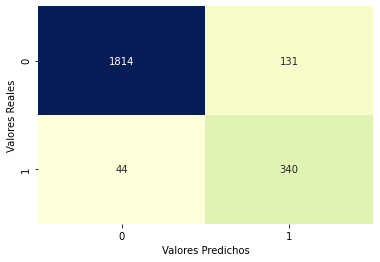

In [200]:
select_k_cols_overs = feature_variation(X_train_overs, X_test_overs, y_train_overs, y_test_overs, k_range)

X_train_overs_select_k = X_train_overs.loc[:,select_k_cols_overs['Columnas Seleccionadas'].tolist()]
X_test_overs_select_k = X_test_overs.loc[:,select_k_cols_overs['Columnas Seleccionadas'].tolist()]

rf_metrics_overs_select_k, rf_pred_proba_overs_select_k = RandomForest_model(X_train_overs_select_k, X_test_overs_select_k, y_train_overs, y_test_overs)
rf_metrics_overs_select_k

#### Performance SelectFromModel

Mayor score logrado en Train: 0.948 - Catindad de variables = 9
Mayor score logrado en Test: 0.8171 - Catindad de variables = 9
La menor diferencia entre scores se da en: 5 variables - diferencia = 0.122

Cantidad de variables seleccionadas: 9


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9477  0.9542     0.9419       0.9412    0.9480  0.9851
Metricas Test     0.9339  0.8958     0.7511       0.9414    0.8171  0.9719

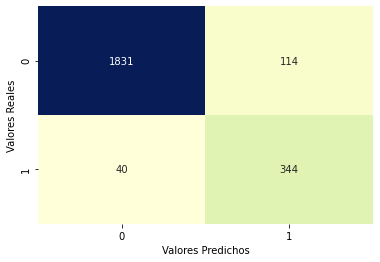

In [201]:
select_model_cols_overs = select_from_model(X_train_overs, X_test_overs, y_train_overs, y_test_overs, feature_range)

X_train_overs_select_model = X_train_overs.loc[:,select_model_cols_overs['Columnas Seleccionadas'].tolist()]
X_test_overs_select_model = X_test_overs.loc[:,select_model_cols_overs['Columnas Seleccionadas'].tolist()]

rf_metrics_overs_select_model, rf_pred_proba_overs_select_model = RandomForest_model(X_train_overs_select_model, X_test_overs_select_model, y_train_overs, y_test_overs)
rf_metrics_overs_select_model

#### Performance RFE

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9373  0.9417     0.9335       0.9329    0.9376  0.9837
Metricas Test     0.9167  0.8464     0.7065       0.9306    0.7701  0.9667

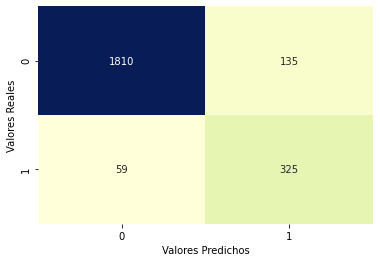

In [202]:
X_train_overs_rfe = X_train_overs.loc[:,rfe_cols_overs['Columnas Seleccionadas'].tolist()]
X_test_overs_rfe = X_test_overs.loc[:,rfe_cols_overs['Columnas Seleccionadas'].tolist()]

rf_metrics_overs_rfe, rf_pred_proba_overs_rfe = RandomForest_model(X_train_overs_rfe, X_test_overs_rfe, y_train_overs, y_test_overs)
rf_metrics_overs_rfe

#### Performance RFECV

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9461  0.9542     0.9391       0.9381    0.9466  0.9852
Metricas Test     0.9261  0.8776     0.7294       0.9357    0.7967  0.9702

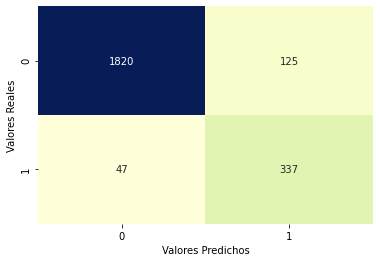

In [203]:
X_train_overs_rfecv = X_train_overs.loc[:,rfecv_cols_overs['Columnas Seleccionadas'].tolist()]
X_test_overs_rfecv = X_test_overs.loc[:,rfecv_cols_overs['Columnas Seleccionadas'].tolist()]

rf_metrics_overs_rfecv, rf_pred_proba_overs_rfecv = RandomForest_model(X_train_overs_rfecv, X_test_overs_rfecv, y_train_overs, y_test_overs)
rf_metrics_overs_rfecv

#### Comparacion entre modelos.
<img src="img/modelo_rf_overs.png" width=30% height=25%> <b> Modelo R.F. Oversample </b>

Al comparar los cuatro modelos de seleccion de features contra el modelo al que solo se le aplico Oversample, podemos decir que, en todos los casos se pudo observar una mejora en la performance, tanto en las metricas de train como las de test, podemos decir que sin importar el metodo de seleccion de features, de los que aplicamos, logro mejorar en cierta medida la performance general del modelo.

Ademas, en cada modelo, podemos ver la diferencia entre los valores de train y test como disminuye, por lo tanto podemos decir que al aplicar estas tecnicas reducimos la dimensionalidad del dataset y ademas reducimos en cierta medida (dependiendo la tecnica) el overfitting.

El modelo que logro un mejor aumento en la performance fue el de SelectFromModel.
Logrando la menor cantidad de falsos negativos, eso se puede observar en la metricas de Recall. El valor de F1 tambien es el mas elevado de los cuatro modelos, lo que indicaria que es el mas equilibrado de los cuatro. 

SelectKBest y RFE, lograron una mayor reduccion en la deteccion de falsos postivos, por lo tanto los valores de specificity y precision son los mas elevados de los cuatro modelos.

RFE, logro mejorar muy poco la performance, pero logro reducir la dimensionalidad del dataset mejorando muy levemente el modelo.

RFECV, fue el que logro reducir en mayor medida los valores de falsos negativos, puede observarse que logro las mayores metricas en Recall.

Si bien se esperaba que el modelo que mejor performe fuera RFECV, podemos ver por las metricas y por la curva ROC que no fue asi. El modelo que mejor performo fue SelectFromModel.

In [204]:
modelos = [[y_test_overs, rf_pred_proba_overs, 'R.F. Oversample'],
           [y_test_overs, rf_pred_proba_overs_select_k, 'R.F. Oversample - SelectKBest'],
           [y_test_overs, rf_pred_proba_overs_select_model, 'R.F. Oversample - SelectFromModel'],
           [y_test_overs, rf_pred_proba_overs_rfe, 'R.F. Oversample - RFE'],
           [y_test_overs, rf_pred_proba_overs_rfecv, 'R.F. Oversample - RFECV']]

roc_curves(values=modelos)

### Modelo Undersampleado

Ahora realizaremos lo mismo que acabamos de realizar pero lo haremos para el modelo al cual se le aplico un undersample.

#### SelectKBest

In [205]:
k_range = np.arange(1, len(X_train_unders.columns)+1, 1)
select_k_cols_unders = feature_variation(X_train_unders, X_test_unders, y_train_unders, y_test_unders, k_range, plot=False)
plot_cols_seleccionadas(X_train_overs, select_k_cols_unders, 'SelectKBest-Undersample')
select_k_cols_unders.sort_values('Columnas Seleccionadas', ascending=True)


Cantidad de variables seleccionadas: 9


Columnas Seleccionadas
8     Avg_Utilization_Ratio
2     Contacts_Count_12_mon
1    Months_Inactive_12_mon
4      Total_Amt_Chng_Q4_Q1
7       Total_Ct_Chng_Q4_Q1
0  Total_Relationship_Count
3       Total_Revolving_Bal
5           Total_Trans_Amt
6            Total_Trans_Ct

#### SelectFromModel

In [206]:
feature_range = np.arange(1, len(X_train_unders.columns)+1)
select_model_cols_unders = select_from_model(X_train_unders, X_test_unders, y_train_unders, y_test_unders, feature_range, plot=False)
plot_cols_seleccionadas(X_train_overs, select_model_cols_unders, 'SelectFromModel-Undersample')
select_model_cols_unders.sort_values('Columnas Seleccionadas', ascending=True)


Cantidad de variables seleccionadas: 9


Columnas Seleccionadas
3           Avg_Open_To_Buy
8     Avg_Utilization_Ratio
1              Credit_Limit
4      Total_Amt_Chng_Q4_Q1
7       Total_Ct_Chng_Q4_Q1
0  Total_Relationship_Count
2       Total_Revolving_Bal
5           Total_Trans_Amt
6            Total_Trans_Ct

#### RFE

In [207]:
rfe_cols_unders = feature_selection_rfe(X_train_unders, y_train_unders)
plot_cols_seleccionadas(X_train_overs, rfe_cols_unders, 'RFE-Undersample')
rfe_cols_unders.sort_values('Columnas Seleccionadas', ascending=True)

Cantidad de variables seleccionadas: 14


Columnas Seleccionadas
6            Avg_Open_To_Buy
1      Avg_Utilization_Ratio
9      Contacts_Count_12_mon
8               Credit_Limit
0               Customer_Age
7                   Gender_M
10    Months_Inactive_12_mon
12            Months_on_book
5       Total_Amt_Chng_Q4_Q1
2        Total_Ct_Chng_Q4_Q1
11  Total_Relationship_Count
13       Total_Revolving_Bal
4            Total_Trans_Amt
3             Total_Trans_Ct

#### RFECV

In [208]:
rfecv_cols_unders = feature_selection_rfecv(X_train_unders, y_train_unders)
plot_cols_seleccionadas(X_train_overs, rfecv_cols_unders, 'RFECV-Undersample')
rfecv_cols_unders.sort_values('Columnas Seleccionadas', ascending=True)

Cantidad de variables seleccionadas: 11


Columnas Seleccionadas
6            Avg_Open_To_Buy
0      Avg_Utilization_Ratio
3      Contacts_Count_12_mon
4               Credit_Limit
2     Months_Inactive_12_mon
7       Total_Amt_Chng_Q4_Q1
10       Total_Ct_Chng_Q4_Q1
1   Total_Relationship_Count
5        Total_Revolving_Bal
8            Total_Trans_Amt
9             Total_Trans_Ct

Puede apreciarse una diferencia entre las variables seleccionadas, al compara las tecnicnas de undersample y oversample.

SelectKBest y SelectFromModel seleccionaron la misma cantidad de variables, y fueron los que menos variables seleccionaron.

Aqui paso lo mismo con RFE y RECV Puede verse que las columnas seleccionadas por RFECV tambien fueron seleccionadas por RFE, como mencionamos previamente.

Las columnas que fueron seleccionadas por todos los modelos fueron:

In [209]:
# Creo una funcion lambda para recorrer cada registro de las columnas seleccionadas mediante SelectKBest
# y las comparo con una por una con los demas modelos.
mask = select_k_cols_unders['Columnas Seleccionadas'].apply(lambda x: True if x in select_model_cols_unders['Columnas Seleccionadas'].tolist() else False)
cols_iguales = select_k_cols_unders[mask]

mask = cols_iguales['Columnas Seleccionadas'].apply(lambda x: True if x in rfe_cols_unders['Columnas Seleccionadas'].tolist() else False)
cols_iguales = cols_iguales[mask]

mask = cols_iguales['Columnas Seleccionadas'].apply(lambda x: True if x in rfecv_cols_unders['Columnas Seleccionadas'].tolist() else False)

plot_cols_seleccionadas(X_train_overs, cols_iguales[mask], 'Coincidentes-Undersample')
cols_iguales[mask].sort_values('Columnas Seleccionadas', ascending=True).reset_index(drop=True)

Columnas Seleccionadas
0     Avg_Utilization_Ratio
1      Total_Amt_Chng_Q4_Q1
2       Total_Ct_Chng_Q4_Q1
3  Total_Relationship_Count
4       Total_Revolving_Bal
5           Total_Trans_Amt
6            Total_Trans_Ct

Al comparar las columnas que adoptaron todos los modelos de Oversample contra los de Undersample podemos ver que varias son iguales a excepcion de dos columnas.

Podemos decir que SelectKBest es el modelo menos conservativo, ya que descarta una mayor cantidad de variables.

RFE es el modelo mas conservativo, tanto en oversample como en undersample, conserva la mayor cantidad de variables. 

RFECV performa igual que RFE con la unica variacion, de que como lo dice le nombre, al aplicar Cross Validation logra reducir un poco mas las variables seleccionadas.

Todas las tecnicas de Feature selection mantuvieron la cantidad de variables seleccionadas sin importar la tecnica de balanceo de clases que se aplique.

#### Performance SelectKBest

Mayor score logrado en Train: 0.9419 - Catindad de variables = 9
Mayor score logrado en Test: 0.7995 - Catindad de variables = 9
La menor diferencia entre scores se da en: 9 variables - diferencia = 0.142

Cantidad de variables seleccionadas: 9


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9415  0.9497     0.9343       0.9332    0.9419  0.9819
Metricas Test     0.9240  0.9193     0.7074       0.9249    0.7995  0.9727

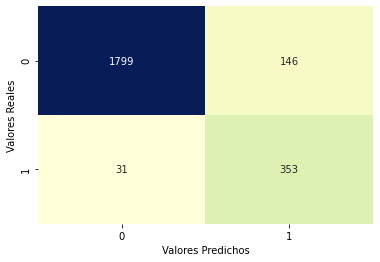

In [210]:
select_k_cols_unders = feature_variation(X_train_unders, X_test_unders, y_train_unders, y_test_unders, k_range)

X_train_unders_select_k = X_train_unders.loc[:,select_k_cols_unders['Columnas Seleccionadas'].tolist()]
X_test_unders_select_k = X_test_unders.loc[:,select_k_cols_unders['Columnas Seleccionadas'].tolist()]

rf_metrics_unders_select_k, rf_pred_proba_unders_select_k = RandomForest_model(X_train_unders_select_k, X_test_unders_select_k, y_train_unders, y_test_unders)
rf_metrics_unders_select_k

#### Performance SelectFromModel

Mayor score logrado en Train: 0.9418 - Catindad de variables = 11
Mayor score logrado en Test: 0.7914 - Catindad de variables = 9
La menor diferencia entre scores se da en: 10 variables - diferencia = 0.146

Cantidad de variables seleccionadas: 9


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9402  0.9506     0.9312       0.9297    0.9408  0.9830
Metricas Test     0.9206  0.9141     0.6978       0.9219    0.7914  0.9725

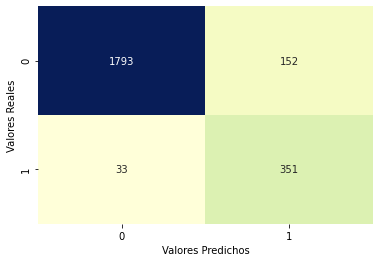

In [211]:
select_model_cols_unders = select_from_model(X_train_unders, X_test_unders, y_train_unders, y_test_unders, feature_range)

X_train_unders_select_model = X_train_unders.loc[:,select_model_cols_unders['Columnas Seleccionadas'].tolist()]
X_test_unders_select_model = X_test_unders.loc[:,select_model_cols_unders['Columnas Seleccionadas'].tolist()]

rf_metrics_unders_select_model, rf_pred_proba_unders_select_model = RandomForest_model(X_train_unders_select_model, X_test_unders_select_model, y_train_unders, y_test_unders)
rf_metrics_unders_select_model

#### Performance RFE

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9337  0.9471     0.9223       0.9202    0.9345  0.9829
Metricas Test     0.9124  0.9219     0.6705       0.9105    0.7763  0.9697

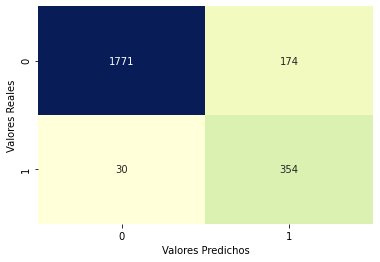

In [212]:
X_train_unders_rfe = X_train_unders.loc[:,rfe_cols_unders['Columnas Seleccionadas'].tolist()]
X_test_unders_rfe = X_test_unders.loc[:,rfe_cols_unders['Columnas Seleccionadas'].tolist()]

rf_metrics_unders_rfe, rf_pred_proba_unders_rfe = RandomForest_model(X_train_unders_rfe, X_test_unders_rfe, y_train_unders, y_test_unders)
rf_metrics_unders_rfe

#### Performance RFECV

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9441  0.9592      0.931       0.9289    0.9449  0.9826
Metricas Test     0.9206  0.9271      0.694       0.9193    0.7938  0.9719

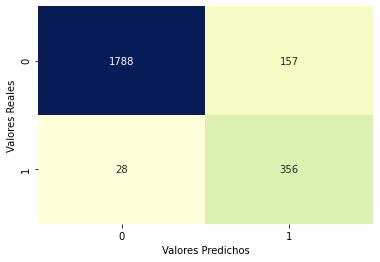

In [213]:
X_train_unders_rfecv = X_train_unders.loc[:,rfecv_cols_unders['Columnas Seleccionadas'].tolist()]
X_test_unders_rfecv = X_test_unders.loc[:,rfecv_cols_unders['Columnas Seleccionadas'].tolist()]

rf_metrics_unders_rfecv, rf_pred_proba_unders_rfecv = RandomForest_model(X_train_unders_rfecv, X_test_unders_rfecv, y_train_unders, y_test_unders)
rf_metrics_unders_rfecv

#### Comparacion entre modelos
<img src="img/modelo_rf_unders.png" width=30% height=25%> <b> Modelo R.F. Undersample </b>

Nuevamente podemos observar una mejora en la performance al comparar los cuatro modelos contra el que unicamente se aplico Undersample, tanto en las metricas de train como las de test.

SelectFromModel, en este caso fue el que mejor performo de las cuatro tecnicas planteadas, fue el que logro una mayor reduccion en la deteccion de falsos positivos y negativos, ademas de lograr las metricas mas elevadas.

RFE, bajo en pequeña medida la deteccion de falsos negativos, pero mantuvo la cantidad los falsos positivos. En este caso aplicar esta tecnica no trajo ninguna mejora significativa al modelo.

RFECV, performo mejor que RFE, como era de esperarse, pero aun asi no performo tan bien como SelectFromModel, bajo la cantidad de flasos negativos y positivos detectados, pero en menor cantiad que el otro modelo mencionado. Esto mencionado se puede observar en las metricas.

Veremos en la curva ROC lo que mencionamos recien, puede verse que el modelo que mas se ajusta al modelo perfecto es el que se le aplico la tecnica de SelectFromModel, luego SelectKBest, si bien este ultimo logro un mayor valor AUC, esto no se ve reflejado en la grafica.

Ademas puede verse que el modelo RFE pareciera que es "peor" que el modelo de Undersample.

In [214]:
modelos = [[y_test_unders, rf_pred_proba_unders, 'R.F. Undersample'],
           [y_test_unders, rf_pred_proba_unders_select_k, 'R.F.Undersample - SelectKBest'],
           [y_test_unders, rf_pred_proba_unders_select_model, 'R.F.Undersample - SelectFromModel'],
           [y_test_unders, rf_pred_proba_unders_rfe, 'R.F.Undersample - RFE'],
           [y_test_unders, rf_pred_proba_unders_rfecv, 'R.F.Undersample - RFECV']]

roc_curves(values=modelos)

#### Compararemos los mejores modelos.

Seleccionaremos el modelo que mejor performo, tanto para Undersample como Oversample fue SlectFromModel. Y compararemos estos dos resultados con los modelos a los que solo se le aplico una tecnica de resampleo, asi de esa manera podremos seleccionar el mejor de los dos modelos para poder continuar con el.

In [215]:
modelos = [[y_test_overs, rf_pred_proba_overs, 'R.F. Oversample'],
           [y_test_unders, rf_pred_proba_unders, 'R.F. Undersample'],
           [y_test_overs, rf_pred_proba_overs_select_model, 'R.F. Oversample - SelectFromModel'],
           [y_test_unders, rf_pred_proba_unders_select_model, 'R.F. Undersample - SelectFromModel']]

roc_curves(values=modelos)

Aqui se puede observar que como vimos con las metricas el mejor modelo es aquel al que se le aplico en primera instancia un balanceo de clases, Oversample mediante SMOTENC y luego se seleccionaron las features mediante SelectKBest, por lo tanto nos quedaremos con este modelo para seguir aplicandole tecnicas para ver si podremos reducir el overfitting.

## Feature Extraction

La idea de estos metodos es construir nuevas variables como combinacion de las existentes, luego seleccionar aquellas variables mas importantes que son las que usaremos para construir nuestros modelos. 

Aplicaremos PCA (Principal Component Analisis), el cual es un algoritmo de aprendizaje no superisado, aplicado a la reduccion de dimensiones. Este algoritmo puede ser utilizado como parte del preprocesamiento de datos, en este caso es aplicado para:
- Reducir el numero de dimensiones
- Reducir el ruido de los datos (nuestro caso), ya que PCA es computado encontrando los componentes que explican la mayor cantidad de varianza, "captura la señal de los datos y omite el ruido"

PCA implementa un proceso de feature extraction, donde se crean nuevas variables, los componentes principales (CP o PC), nos quedamos con un subconjunto de ellos intenteando minimizar la perdida de informacion.

Este algoritmo tiene ventajas asi como tambien tiene desventajas.

- Ventajas de PCA:
    - Facilidad en el computo computacional, ya que esta basado en algebra linear, el cual es facil para ser computado por las computadoras.
    - Acelera y mejora la performance de otros algoritmos de machine learning, los algoritmos de machine learning convergen mas rapido cuando son entrenados con Componentes principales en vez de los datos originales
    - Contrarresta el problema de la gran dimensionalidad de los datos, estos datos de mucha dimensionalidad puede causar que los algoritmos de regresion overfitteen facilmente. Al usar PCA previamente para bajar la dimensionalidad del dataset, prevenimos que estos algorimos overfitteen.

- Desventajas de PCA:
    - Baja interpretabilidad de los componentes principales, Los componentes principales como dijimos son combinaciones lineales de las features del dataset original, pero no son faciles de interpretar. Es dificil saber cuales son las features mas importantes del dataset despues de computar principal components.
    - El intercambio entre perder informacion y reducir la dimensionalidad, aunque la reduccion de la dimensionalidad es util, viene con un costo, la perdida de informacion es una parte necesaria de PCA. Realizar un balance entre reducir la dimensionalidad y perder informacion es un compromiso que tenemos que hacer al usar PCA. 

A continuacion generaremos varios modelos a los cuales le aplicaremos PCA

Crearemos una funcion la cual tome un DataFrame con las columnas para aplicarle PCA, y me devolvera:
- Un Dataset con una cantidad de dimensiones igual al espacio de las features originales, para asi determinar con que cantidad de componentes quedarnos (podemos reducir la dimensionalidad del dataset original, conservando la mayor cantidad de informacion posible).
- Un Grafico del ratio de la varianza explicada en funcion de la cantidad de componentes, este grafico nos permitiria tambien usar la tecnica del codo para seleccionar la cantidad de componentes principales (el punto donde se quiebra la curva o bien donde el descenso se estabiliza)

In [216]:
# Funcion para seleccionar features mediante PCA
# Toma un DataFrame con los datos de Train y otro con los datos de Test, se le aplicara directemente PCA.
# Ambos ya previamente normalizados y con las clases de train resampleadas.
def feature_extraction_pca(X_train, X_test, scale_at_end = True, plot=True):
    # Instancio la clase PCA (sin argumentos asi conservamos todos los CP), fiteo y transformos Train, transformo Test.
    pca = PCA(random_state=13)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)    
    
    # Cantidad de Componentes Principales.
    cps = np.arange(1,pca.components_.shape[0] + 1)
    # Ratio de varianza explicada, de cada componente principal.
    indiv_variance_ratio = pca.explained_variance_ratio_
    # Ratio de varianza explicada acumulada.
    acum_variance_ratio = np.cumsum(indiv_variance_ratio)
    
    # Creamos un DataFrame con las componentes principales y el ratio de la varianza explicada individual y acumulada.
    data_plot = pd.DataFrame({'Varianza Individual' : indiv_variance_ratio, 'Varianza Acumulada' : acum_variance_ratio}, index=cps)
    
    if plot:
        # Creamos la figura para plotear.
        fig = go.Figure()
        # Agrego la varianza individual al grafico.
        fig.add_trace(go.Scatter(x = data_plot.index, y = data_plot['Varianza Individual'], mode = 'lines+markers', name = 'Varianza Individual'))
        # Agrego la varianza accumulada al grafico.
        fig.add_trace(go.Scatter(x = data_plot.index, y = data_plot['Varianza Acumulada'], mode = 'lines+markers', name = 'Varianza Acumulada'))
        
        fig.update_layout(height=650, width=1000, title = 'Varianza explicada en funcion de las componentes principales',
                        xaxis_title = 'Componentes Principales', yaxis_title = 'Porcentaje de varianza explicada')
        fig.show()
    
    # Devuelvo el DataFrame transformado con las componentes principales.
    X_pca_train = pd.DataFrame(data = X_train_pca, columns = ['CP'+str(x) for x in cps], index= X_train.index)
    
    X_pca_test = pd.DataFrame(data = X_test_pca, columns = ['CP'+str(x) for x in cps], index=X_test.index)
    
    if scale_at_end:
        # Escalamos los datos cuando combinemos PCs con otro tipo de variables, ya que los PCs y las otras variables tendran escalas distintas.
        scaler = StandardScaler()
        X_pca_train = pd.DataFrame(data= scaler.fit_transform(X_pca_train),columns=X_pca_train.columns, index=X_pca_train.index)
        X_pca_test = pd.DataFrame(data = scaler.transform(X_pca_test), columns=X_pca_test.columns, index= X_pca_test.index)
        
    return X_pca_train, X_pca_test

Utilizaremos la siguiente funcion para evaluar los componentes principales que me arroja la funcion anterior, asi podremos ver la variacion de los F1-Scores de Train y de F1-Scores de test de un modelo RandoForest a medida que adopto mayor cantidad de Componentes Principales.

Esta funcion ira agregando un componente principal a la vez, asi de esa manera el modelo evaluara teniendo en cuenta las componentes principales secuencialmente. Primero comenzara por la [PC1], modelara un modelo de RandomForest y obtendra las metricas de F1-score de Train y F1-Score de Test. Una vez realizado eso considerara la siguiente componente principal junto con las anteriores, las ira concatenando [PC1, PC2], asi de esa manera ira evaluando las distintas componentes principales hasta [PC1, PC2, ..., PCn].

En caso de que el dataset al que se le aplicara RF tenga variables que no sean Componentes Principales, la funcion concatenara dichas variables a las CP y las evaluara como mencionamos recien.

Esta funcion me devolvera:
- Un grafico en el cual veremos la variacion de la metrica F1-Score tanto para train como para test, asi de esa manera vemos que modelo performo mejor de acuerdo a la cantidad de componentes principales que adoptemos para reducir la dimensionalidad.
- Dos dataframes uno con los datos de train y otro con los datos de train, cada uno con las columnas que lograron el mayor valor de la metrica F1.

In [217]:
# Evalua para cada componente principal las metricas F1 para Train y Test.
# X_pca_train - X_pca_test : Son los DF con las componentes principales devuelto por la funcion anterior
# y_train - y_test : Variable target separada en train y test
# X_features_train - X_features_test : Variables de feature que no fueron incluidas en la funcion anterior, pero son parte del modelo a evaluar. 
def evaluar_pcs (X_pca_train, X_pca_test, y_train, y_test, X_features_train = pd.DataFrame(), X_features_test = pd.DataFrame(), plot=True):
     
    # Me fijo si hay variables a las cuales no se les haya aplicado PCA,
    if not X_features_train.empty and not X_features_test.empty:
        # Concateno los PCs con las variables a las que no se les aplico PCA.
        X_train_fun = pd.concat([X_pca_train, X_features_train], axis=1)
        X_test_fun = pd.concat([X_pca_test, X_features_test], axis=1)
    
    # En caso de que falte DF features de test o train.
    elif (not X_features_train.empty and X_features_test.empty) or (not X_features_test.empty and X_features_train.empty):
        return print('Falta argumento en funcion - Feature Test/Train')
        
    # En caso de que no haya variables adicionales a las de PCA.
    else:
        # Renombro mis variables de Train y Test.
        X_train_fun = X_pca_train
        X_test_fun = X_pca_test
    
    # Creamos rango para iterar, recorrera todos los PCs.
    range_pc = np.arange(len(X_pca_train.columns))
    
    # Lista para guardar valores de F1-score de Train.
    f1_train = []
    # Lista para guardar valores de F1-Score de Test.
    f1_test = []
    # Lista para guardar las columnas que se utilizan en cada modelo, asi luego sera mas facil recuperarlas.
    columnas = []
    # Itero por cada PC que tengo en el dataset arrojado por la funcion 'feature_extraction_pca'.
    for i in range_pc:
        
        # Rango de PCs a incluir, voy a ir incluyendo de a una en cada loop.
        # 1er iteracion - [CP1]
        # 2da iteracion - [CP1 , CP2]
        # n iteracion - [CP1, CP2, ..., CPn]
        pc_incluir = np.arange(0,i+1)
        
        # Si tengo mas variables que mis CPs.        
        if not (X_features_train.empty and X_features_test.empty):
            # Obtengo el nombre de las columnas que no son PC en una lista.
            feature_cols = X_features_train.columns.tolist()
            
            # Recorro los nombres de los PC que voy a incluir y los agrego a la lista anterior.    
            for cp in X_pca_train.columns[pc_incluir]:
                feature_cols.append(cp)
                
        # En caso de que no tenga otras variables.
        else:
            # Voy a utilizar las columnas de cada PC.
            feature_cols = X_pca_train.columns[pc_incluir]
        
        # Selecciono mis features a utilizar
        X_train_loop = X_train_fun[feature_cols]         
        X_test_loop = X_test_fun[feature_cols]
        
        # Predigo con mi modelo RandomForest.
        data_resultado, y_pred_proba = RandomForest_model(X_train_loop, X_test_loop, y_train, y_test, plot_conf_mat=False)
        
        # Me quedo con el F1-Score de train y lo agrego a la lista.
        f1_train.append(data_resultado.loc['Metricas Train', 'F1-Score'])

        # Me qudo con el F1-Score de train y lo agrego a la lista.
        f1_test.append(data_resultado.loc['Metricas Test', 'F1-Score'])
        
        # Agrego a la lista, las columnas que uso el modelo del loop.
        columnas.append(X_train_loop.columns.tolist())

    # Creo DataFrame con todos los valores F1 para cada PC.    
    data_f1 = pd.DataFrame({'F1-Train' : f1_train, 'F1-Test' : f1_test, 'CPs' : X_pca_train.columns, 'Columnas' : columnas})

    # Obtengo el valor mas alto de F1-Score Test.
    data_test_max = data_f1.loc[data_f1['F1-Test'].idxmax(),['F1-Test', 'CPs', 'Columnas']]
    
    if plot:
        print('Mayor score logrado en Test:', data_test_max['F1-Test'],'-', data_test_max['CPs'])
        
        # Creamos la figura para plotear.
        fig = go.Figure()
        # Agrego F1-Train al grafico.
        fig.add_trace(go.Scatter(x = data_f1['CPs'], y = data_f1['F1-Train'], mode = 'lines+markers', name = 'F1-Score Train'))
        # Agrego F1-Test al grafico.
        fig.add_trace(go.Scatter(x = data_f1['CPs'], y = data_f1['F1-Test'], mode = 'lines+markers', name = 'F1-Score Train'))
        
        fig.update_layout(height=650, width=1500, title = 'Variacion de F1-Score segun PCs', xaxis_title = 'Componentes Principales', yaxis_title = 'F1-Score')
        fig.show()
    
    # Devuelvo dos Datasets, uno de Train y otro de Test.
    # Con las columnas que obtuvieron el maximo F1-Score Test.
    return X_train_fun[data_test_max['Columnas']], X_test_fun[data_test_max['Columnas']]

Una Vez establecidas las funciones a utilizar plantearemos los modelos a comparar.

#### PCA - DataFrame completo

El primer modelo que plantearemos sera el de aplicar PCA a la totalidad del DataFrame que ya le hemos aplicado Oversample. 

In [218]:
X_train_overs_pca_base, X_test_overs_pca_base = feature_extraction_pca(X_train_overs, X_test_overs, scale_at_end=False)

Del grafico podemos ver la varianza explicada por cada componente principal, puede verse que no tiene un codo muy marcado.

Evaluaremos ahora como performa un modelo RandomForest a medida que vamos considerando una CP a la vez, asi de esa manera obtendremos con cuantas componentes principales quedarnos.

In [219]:
# Evaluamos para cada PC.
X_train_overs_pca_base, X_test_overs_pca_base = evaluar_pcs(X_train_overs_pca_base, X_test_overs_pca_base, y_train_overs, y_test_overs)

Mayor score logrado en Test: 0.6749 - CP20


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.8895  0.8722     0.9034       0.9067    0.8875  0.9597
Metricas Test     0.8755  0.7839     0.5925       0.8936    0.6749  0.9201

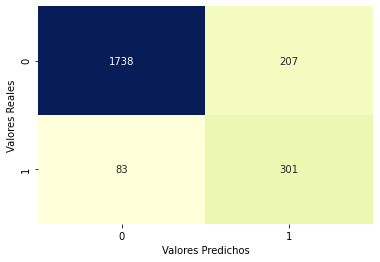

In [220]:
rf_metrics_overs_pca_base, rf_pred_proba_overs_pca_base = RandomForest_model(X_train_overs_pca_base, X_test_overs_pca_base, y_train_overs, y_test_overs)
rf_metrics_overs_pca_base

Comparando este modelo contra al que solo se le aplicamo un Oversample podemos ver que no hubo ninguna mejora en la perfomance, sino que todo lo contrario, me empeoro las predicciones. Aumentaron la cantidad de falsos positivos y negativos.

Por lo tanto aplicar PCA a la totalidad de las variables <b> empeoro </b> la performance.

<img src="img/modelo_rf_overs.png" width=30% height=25%> <b> Modelo R.F. Oversample </b>

### PCA variables dummy

El siguiente modelo consisitira en aplicarle PCA unicamente a las variables dummies. Asi reduciremos la dimensionalidad de mis variables categorias.

Evaluaremos luego el modelo con todas las variables continuas y con las componentes principales de mis variables dummies.

In [221]:
# Primero obtengo mis variables categoricas ya dumificadas, las obtengo del DF de train
# ignorando las columnas numericas que obtuve al principio del trabajo.
dum_cols = [x for x in X_train_overs.columns if x not in num_cols]

# dum_cols tiene el nombre de mis columnas dummificadas, fue definido previo a la aplicacion de SMOTENC.
# Aplico PCA a mis columnas categoricas.
X_train_pcs_dums, X_test_pcs_dums = feature_extraction_pca(X_train_overs[dum_cols], X_test_overs[dum_cols])

In [222]:
# Evaluamos para cada PC. Considerando mis columnas a las cuales les aplique PCA y a las que no.
X_train_overs_pca_dums, X_test_overs_pca_dums = evaluar_pcs(X_train_pcs_dums, X_test_pcs_dums, y_train_overs, y_test_overs, X_features_train= X_train_overs[num_cols], X_features_test= X_test_overs[num_cols])

Mayor score logrado en Test: 0.7836 - CP2


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9430  0.9528     0.9344       0.9331    0.9435  0.9859
Metricas Test     0.9206  0.8724     0.7113       0.9301    0.7836  0.9708

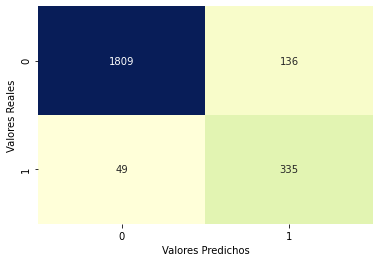

In [223]:
rf_metrics_overs_pca_dums, rf_pred_proba_overs_pca_dums = RandomForest_model(X_train_overs_pca_dums, X_test_overs_pca_dums, y_train_overs, y_test_overs)
rf_metrics_overs_pca_dums

Aqui ya se puede empezar a ver una mejora en la performance, podemos notar como bajo la cantidad de falsos postivos y negativos, en menor medida esta ultima.

Se puede observar que todas las metricas mejoraron sus valores, lo que significa que al aplicar PCA unicamente a las variables dummys, y considerando las columnas continuas estamos mejorando la performance del modelo.

### Feature Importance y PCA

Para este modelo aplicaremos PCA a las variables categoricas nuevamente, pero seleccionaremos las features, que se corresponden a las variables continuas, mediante Feature Importance, estaremos reduciendo en mayor medida la dimensionalidad del dataset.

Por lo tanto lo primero que haremos sera seleccionar mis variables continuas a utilizar. Esto lo haremos mediante la funcion que creamos antes, la cual me devuelve la importancia de cada feature.

In [224]:
# Primero obtengo la importancia de cada variable, para saber con cuales features quedarme
X_train_importancia_pca, X_test_importancia_pca = feature_importance_rf(X_train_overs[num_cols], X_test_overs[num_cols], y_train_overs, y_test_overs, plot_variacion_f1=False,plot_importancia=False)
X_train_importancia_pca.head(2)

Total_Trans_Ct  Total_Trans_Amt  Total_Revolving_Bal  Total_Ct_Chng_Q4_Q1  \
0       -1.188909        -0.774100            -0.147142            -1.444472   
1       -0.071110         0.314103            -0.267451             0.643611   

   Avg_Utilization_Ratio  Months_Inactive_12_mon  Total_Relationship_Count  \
0               1.565188                0.773206                  0.741697   
1               0.374818                1.865454                 -0.549755   

   Contacts_Count_12_mon  Total_Amt_Chng_Q4_Q1  
0               2.361759             -0.727816  
1               0.509898              0.132692

Nos quedamos con las siguientes columnas. La funcion selecciono las mismas columnas que habia seleccionado anteriormente, cuando solo aplicamos feature importance al modelo oversampleado.

Ahora procederemos a evaluar el modelo para cada componente principal, para esto usaremos las componentes principales de las variables dummies que usamos el modelo anterior, ya que seran las mismas a considerar.

In [225]:
# Evaluo el modelo para cada componente principal, no aplico la funcion de PCA a mis variables dummies ya que no es necesario
# por que las tengo del modelo anterior
X_train_overs_feature_importance_pca, X_test_overs_feature_importance_pca = evaluar_pcs(X_train_pcs_dums, X_test_pcs_dums, y_train_overs, y_test_overs, X_features_train= X_train_importancia_pca, X_features_test= X_test_importancia_pca)

Mayor score logrado en Test: 0.787 - CP1


Evaluamos ahora con las variables que obtuvieron el mayor valor de F1.

Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train     0.940  0.9511     0.9304       0.9288    0.9406  0.9849
Metricas Test      0.921  0.8854     0.7083       0.9280    0.7870  0.9700

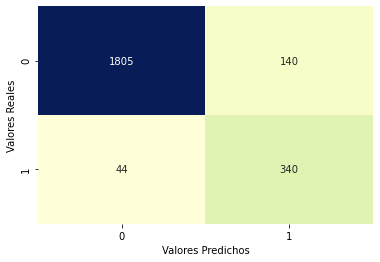

In [226]:
rf_metrics_overs_pca_feature_importance, rf_pred_proba_overs_pca_feature_importance = RandomForest_model(X_train_overs_feature_importance_pca, X_test_overs_feature_importance_pca, y_train_overs, y_test_overs)
rf_metrics_overs_pca_feature_importance

Si comparamos este modelo con el que le aplicamos unicamente feature importance.

<img src="img/modelo_feature_importance.png" width=30% height=25%> <b> Modelo R.F. Oversample - Feature Importance </b>

Podemos notar una leve baja en los falsos positivos, y un aumento de los falsos negativos, en gran medida. 

Al observar las metricas podemos ver que ninguna logro una mejora, por lo tanto podemos decir que aplicar Feature Importance y PCA no mejora la performance del modelo.

### Feature Selection y PCA

Este modelo sera similar al anterior, con la diferencia que la seleccion de features la haremos mediante SelectFromModel. Como dijimos previamente este metodo de filtrado analiza las propiedades estadisticas de cada variable y cuan fuerte es su relacion con la variable target, ademas utiliza el atributo feature_importance_ de RandomForest para seleccionar las variables, son univariados, ya que no contemplan interaccion entre features, se evalua una variable a la vez con la clase.

El echo de que sean univariados es una ventaja ya que podemos evaluar las variables numericas mediante SelectKBest de manera separada y luego agregarlas a mis componentes principales, para ver como performan juntas. Esto con RFECV no podria hacerse ya que este como se dijo, selecciona un subconjunto de features y de acuerdo a la performance obtenida va eliminando o agregando features.

In [227]:
# Primero obtengo las variables seleccionadas por SelectKBest.
k_range = np.arange(1, len(X_train_overs[num_cols].columns)+1, 1)
select_model_pca_cols= select_from_model(X_train_overs[num_cols], X_test_overs[num_cols], y_train_overs, y_test_overs, k_range, plot=False)
select_model_pca_cols


Cantidad de variables seleccionadas: 9


Columnas Seleccionadas
0  Total_Relationship_Count
1    Months_Inactive_12_mon
2     Contacts_Count_12_mon
3       Total_Revolving_Bal
4      Total_Amt_Chng_Q4_Q1
5           Total_Trans_Amt
6            Total_Trans_Ct
7       Total_Ct_Chng_Q4_Q1
8     Avg_Utilization_Ratio

In [228]:
slect_model_pca_cols = select_model_pca_cols['Columnas Seleccionadas'].tolist()

# Evaluo con las variables seleccionadas y los PC de las variables dummies.
X_train_overs_feature_selection_pca, X_test_overs_feature_selection_pca = evaluar_pcs(X_train_pcs_dums, X_test_pcs_dums, y_train_overs, y_test_overs, X_features_train= X_train_overs[slect_model_pca_cols], X_features_test= X_test_overs[slect_model_pca_cols])

Mayor score logrado en Test: 0.8005 - CP1


Accuracy  Recall  Precision  Specificity  F1-Score     AUC
Metricas Train    0.9469  0.9576     0.9375       0.9362    0.9475  0.9859
Metricas Test     0.9270  0.8880     0.7286       0.9347    0.8005  0.9719

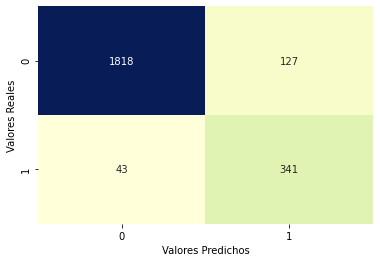

In [229]:
rf_metrics_overs_pca_rfecv, rf_pred_proba_overs_pca_rfecv = RandomForest_model(X_train_overs_feature_selection_pca, X_test_overs_feature_selection_pca, y_train_overs, y_test_overs)
rf_metrics_overs_pca_rfecv

Comparando este modelo con el cual le aplicamos Oversample y luego una seleccion de variables mediante SelectFromModel.

<img src="img/modelo_selectfrommodel_overs.png" width=30% height=25%> <b> Modelo R.F. Oversample - SelectFromModel </b>

Se puede observar que la cantidad de falsos positivos bajo, pero no lo hizo asi la cantidad de falsos negativos, estos aumentaron en cantidad.

Otra cosa para mencionar es que no se observan mejoras en las metricas, tanto las metricas de Train como las de Test bajaron sus valores.

Por lo tanto podemos decir que aplicar PCA a mis variables dummies y luego seleccionar las variables mediante SelectFromModel no mejoro la performance de nuestro modelo.

## Conclusion luego de haber realizado feature engineering.

Podemos decir que para mejorar el overfitting y la performance del modelo sobre este dataset los pasos a seguir son los siguientes:

1- Separar datos en entrenamiento y en test.

2- Escalar las variables continuas, para poder aplicar SMOTENC, ya que como se explico previamente SMOTE se basa en generar muestras mediante la distancia euclideana, y las variables necesitan estar escaladas.

3- Balance de clases, mediante SMOTENC.

4- Dumifico las variables categoricas.

5- Selecciono las features mas importantes utilizando SelectFromModel.

6- Entreno el modelo y evaluo como performa.

En el paso siguiente trataremos de hacer un Pipeline que concatene estos pasos, aqui utilizaremos GridSearch para buscar la mejor combinacion de hiperparametros, para poder mejorar un poco mas la performance del modelo.

# Bibliografia

---
<a href="https://towardsdatascience.com/data-correlation-can-make-or-break-your-machine-learning-project-82ee11039cc9" target="_blank">Good Data and Machine Learning</a>

<a href="https://www.investopedia.com/ask/answers/032515/what-does-it-mean-if-correlation-coefficient-positive-negative-or-zero.asp" target="_blank">What do correlation means?</a>

<a href="https://medium.com/analytics-vidhya/correlation-and-machine-learning-fee0ffc5faac" target="_blank">Correlation and machine learning</a>

<a href="https://www.keboola.com/blog/pca-machine-learning" target="_blank">Guide to Principal Component Analisis (PCA) for Machine Learning</a>
